In [178]:
from DataProcess.visualization import total_score_group_norm, total_score_global_then_group, compare_tasks_across_formats,pivot_scores,add_parse_score,sum_time_per_participant,plot_score_vs_difficulty_by_format,extract_familiarity_dfs,aggregate_interactions
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


tabular_score=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/score_tabular.csv')
config_score=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/score_config.csv')

In [2]:
tabular_score.head()

,participantId,format,total_score,task
0,56cb8858edf8da000b6df354,hjson,0.742656,tabular
1,57c357770e6a1f00015f6038,json,0.535604,tabular
2,5b68c9eb87af310001584803,json5,0.403386,tabular
3,5c6414540821d30001046198,hjson,0.626937,tabular
4,5d30dfa68b1523000134878f,json,0.723415,tabular


In [3]:
config_score.head()

,participantId,format,total_score,task
0,5755c957eb80c4000741a9ce,json5,0.999135,config
1,5795af044a84da00014c5df1,json,0.645161,config
2,57ca4b09993b08000192297b,xml,0.885473,config
3,5b3ec4332a5fbf00014eae57,toml,0.697656,config
4,5c4f5967aac8be0001716a65,xml,0.813149,config


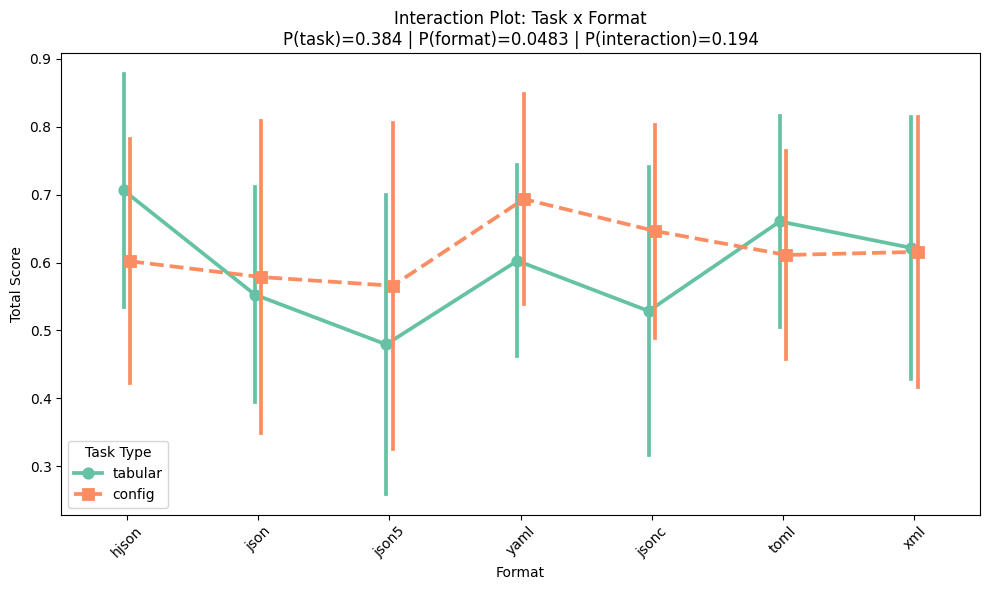

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import statsmodels.api as sm

# 合并数据（如果尚未合并）
df_all = pd.concat([tabular_score, config_score], ignore_index=True)

# 统计检验（Two-way ANOVA）
model = ols('total_score ~ C(format) * C(task)', data=df_all).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# 提取 p 值
p_task = anova_table.loc["C(task)", "PR(>F)"]
p_format = anova_table.loc["C(format)", "PR(>F)"]
p_interaction = anova_table.loc["C(format):C(task)", "PR(>F)"]

# 可视化
plt.figure(figsize=(10, 6))

# 平均值 ± SD
sns.pointplot(
    data=df_all,
    x='format', 
    y='total_score', 
    hue='task',
    dodge=True,
    palette='Set2',
    markers=["o", "s"],   # 点形状：tabular 是圆圈，config 是方块
    linestyles=["-", "--"], # 用虚线/实线区分趋势
    errorbar='sd'
)

# 添加统计显著性信息
plt.title(f"Interaction Plot: Task x Format\n"
          f"P(task)={p_task:.3g} | P(format)={p_format:.3g} | P(interaction)={p_interaction:.3g}")
plt.ylabel("Total Score")
plt.xlabel("Format")
plt.legend(title="Task Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


AttributeError: Line2D.set() got an unexpected keyword argument 'edgecolor'

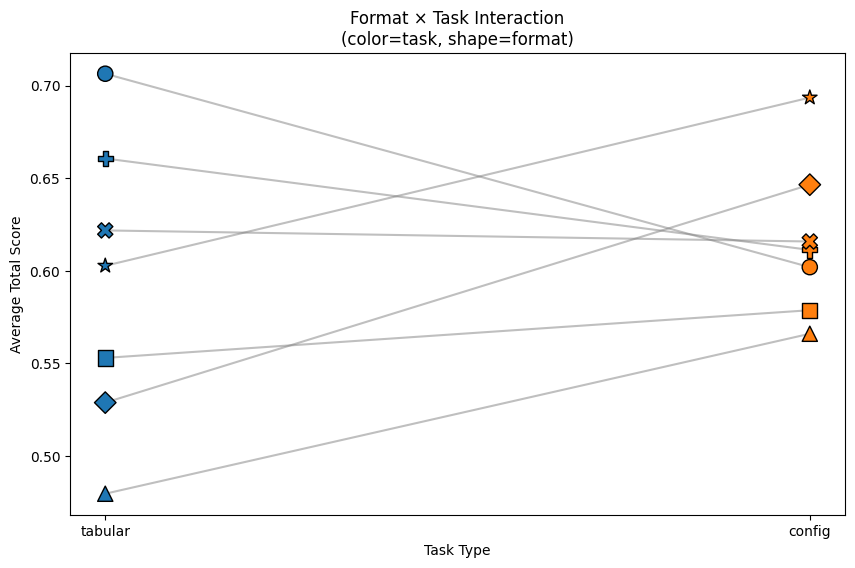

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- 1. 构造或加载你的数据 DataFrame df_all ---
# df_all 必须包含列：['participantId','format','task','total_score']
# task ∈ {'tabular','config'}

# 举例：如果手上有两个 DataFrame tabular_score/config_score
# tabular_score['task']='tabular'
# config_score['task']='config'
df_all = pd.concat([tabular_score, config_score], ignore_index=True)

# --- 2. Tukey HSD 多重比较检验（针对 format） ---
tukey = pairwise_tukeyhsd(
    endog   = df_all['total_score'],
    groups  = df_all['format'],
    alpha   = 0.05
)
# 转成 DataFrame，筛出显著差异对
tukey_df = pd.DataFrame(
    data    = tukey.summary().data[1:],
    columns = tukey.summary().data[0]
)
sig_pairs = tukey_df[tukey_df['p-adj'] < 0.05][['group1','group2','p-adj']]

# --- 3. 计算每种格式在两种任务下的平均分 ---
df_avg = (
    df_all
    .groupby(['format','task'])['total_score']
    .mean()
    .reset_index()
)

# --- 4. 为格式和任务映射 marker & color ---
formats     = sorted(df_avg['format'].unique())
markers     = ['o','s','^','D','P','X','*']  # 至少与格式数目相同
marker_dict = dict(zip(formats, markers))
color_dict  = {'tabular':'C0', 'config':'C1'}

# --- 5. 绘图 ---
plt.figure(figsize=(10,6))

for fmt in formats:
    # 提取该格式在两种任务下的平均分
    sub = df_avg[df_avg['format']==fmt].set_index('task').loc[['tabular','config']]
    x = [0,1]  # 0 对应 tabular, 1 对应 config
    y = sub['total_score'].values
    # 用灰线连接两点
    plt.plot(x, y, color='gray', alpha=0.5, zorder=1)
    # 分别 plot 两个点：颜色区分任务，shape 区分格式
    plt.scatter(
        x, y,
        c=[color_dict['tabular'], color_dict['config']],
        marker=marker_dict[fmt],
        s=120,
        edgecolor='k',
        label=fmt if fmt not in plt.gca().get_legend_handles_labels()[1] else ""
    )

# 坐标与标题
plt.xticks([0,1], ['tabular','config'])
plt.xlabel("Task Type")
plt.ylabel("Average Total Score")
plt.title("Format × Task Interaction\n(color=task, shape=format)")

# 在图右侧列出显著差异的格式对
if not sig_pairs.empty:
    txt = "Significant format pairs (Tukey HSD, α=0.05):\n" + \
          "\n".join([f"{a} vs {b} (p={p:.3f})"
                     for a,b,p in sig_pairs.values])
    plt.gca().text(
        1.02, 0.5, txt,
        transform=plt.gca().transAxes,
        fontsize=10, color='red', va='center'
    )

# 构造图例：上面 scatter 已经为每种格式留了一个 entry
# 我们再手动添加一个任务的 color 图例示例
handles, labels = plt.gca().get_legend_handles_labels()
# 确保格式图例靠前，然后添加颜色示例
handles += [
    plt.Line2D([0],[0], marker='o', color='w', label='tabular',
               markerfacecolor=color_dict['tabular'], markersize=10, edgecolor='k'),
    plt.Line2D([0],[0], marker='o', color='w', label='config',
               markerfacecolor=color_dict['config'], markersize=10, edgecolor='k'),
]
labels  += ['tabular','config']
plt.legend(handles, labels, title="Format / Task", bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.show()



AttributeError: Line2D.set() got an unexpected keyword argument 'edgecolor'

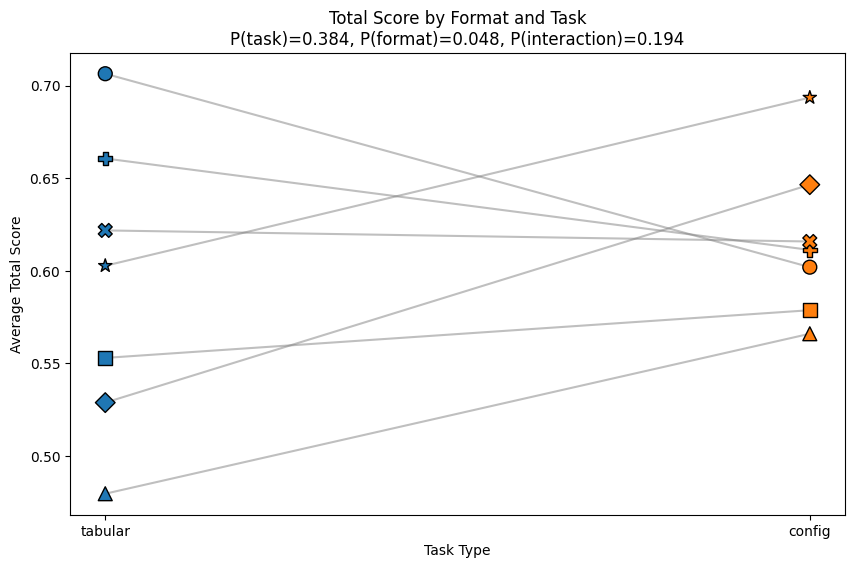

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# —— 1. 准备数据 —— #
# 假设你已经有一个 DataFrame df_all，包含列：
# ['participantId', 'format', 'task', 'total_score']
# task ∈ {'tabular','config'}

# —— 2. 两因素 ANOVA —— #
model = ols('total_score ~ C(format) * C(task)', data=df_all).fit()
anova = sm.stats.anova_lm(model, typ=2)
p_task         = anova.loc['C(task)',       'PR(>F)']
p_format       = anova.loc['C(format)',     'PR(>F)']
p_interaction  = anova.loc['C(format):C(task)', 'PR(>F)']

# —— 3. 计算每种格式在两种任务下的平均 total_score —— #
df_avg = (
    df_all
    .groupby(['format','task'])['total_score']
    .mean()
    .reset_index()
)

# —— 4. 映射颜色和形状 —— #
formats    = sorted(df_avg['format'].unique())
markers    = ['o','s','^','D','P','X','*']  # 至少与格式数量一致
marker_map = dict(zip(formats, markers))
color_map  = {'tabular':'C0', 'config':'C1'}

# —— 5. 绘图 —— #
plt.figure(figsize=(10,6))
for fmt in formats:
    sub = df_avg[df_avg['format']==fmt]
    # x=0 对应 tabular, x=1 对应 config
    x = [0, 1]
    y = [
        sub.loc[sub['task']=='tabular','total_score'].values[0],
        sub.loc[sub['task']=='config', 'total_score'].values[0]
    ]
    # 连线
    plt.plot(x, y, color='gray', alpha=0.5, zorder=1)
    # 两点：颜色区分任务，shape 区分格式
    plt.scatter(
        x, y,
        c=[color_map['tabular'], color_map['config']],
        marker=marker_map[fmt],
        s=100,
        edgecolor='k',
        label=fmt if fmt not in plt.gca().get_legend_handles_labels()[1] else ""
    )

# 坐标与标题
plt.xticks([0,1], ['tabular','config'])
plt.xlabel("Task Type")
plt.ylabel("Average Total Score")
plt.title(
    "Total Score by Format and Task\n"
    f"P(task)={p_task:.3f}, "
    f"P(format)={p_format:.3f}, "
    f"P(interaction)={p_interaction:.3f}"
)

# 构造图例：格式 + 数据类型
handles, labels = plt.gca().get_legend_handles_labels()
# 添加数据类型示例
from matplotlib.lines import Line2D
handles += [
    Line2D([0],[0], marker='o', color='w', label='tabular',
           markerfacecolor=color_map['tabular'], markersize=8, edgecolor='k'),
    Line2D([0],[0], marker='o', color='w', label='config',
           markerfacecolor=color_map['config'], markersize=8, edgecolor='k'),
]
labels  += ['tabular','config']
plt.legend(handles, labels, title="Format (shape) / Task (color)",
           bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.show()


In [9]:
total_time_config=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/total_time_config.csv')
total_time_tabular=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/total_time_tabular.csv')

In [11]:
df_time = pd.concat([total_time_config, total_time_tabular], ignore_index=True)
df_time

,participantId,format,duration_sec_total,normalized_time_total,task
0,5755c957eb80c4000741a9ce,json5,525.249,441.533857,config
1,5795af044a84da00014c5df1,json,1072.223,942.521697,config
2,57ca4b09993b08000192297b,xml,1377.105,1208.896772,config
3,5b3ec4332a5fbf00014eae57,toml,2121.904,2119.289301,config
4,5c4f5967aac8be0001716a65,xml,1465.416,1220.041467,config
...,...,...,...,...,...
207,67f1a4f8dd44e7cd5adffa29,json5,2289.826,2258.360746,tabular
208,67f1c7bd6f1c4a3d8deae02f,toml,2125.076,2176.163343,tabular
209,67f3619e16d4ca195fbd1bd0,yaml,2662.899,2906.184653,tabular
210,67f5bb69760b211cdfe8021c,jsonc,1737.169,1421.827409,tabular


In [13]:
df_merged = pd.merge(
    df_all,
    df_time[['participantId','format','task','duration_sec_total']],
    on=['participantId','format','task'],
    how='inner'    # or 'left' 保留所有分数
)
df_merged

,participantId,format,total_score,task,duration_sec_total
0,56cb8858edf8da000b6df354,hjson,0.742656,tabular,899.197
1,57c357770e6a1f00015f6038,json,0.535604,tabular,951.163
2,5b68c9eb87af310001584803,json5,0.403386,tabular,901.443
3,5c6414540821d30001046198,hjson,0.626937,tabular,2613.853
4,5d30dfa68b1523000134878f,json,0.723415,tabular,1574.851
...,...,...,...,...,...
207,680ebf035ab59d342f31726e,hjson,0.863388,config,2457.674
208,681374d36d7bd7ccb6f914f5,json5,0.914926,config,737.711
209,68138e7f96395f4c5f3a0a87,json,0.375435,config,1319.207
210,6818ca1523ece90f671e3601,json,0.432629,config,2413.983


/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_55413/1833983629.py:27: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot(


AttributeError: Line2D.set() got an unexpected keyword argument 'edgecolor'

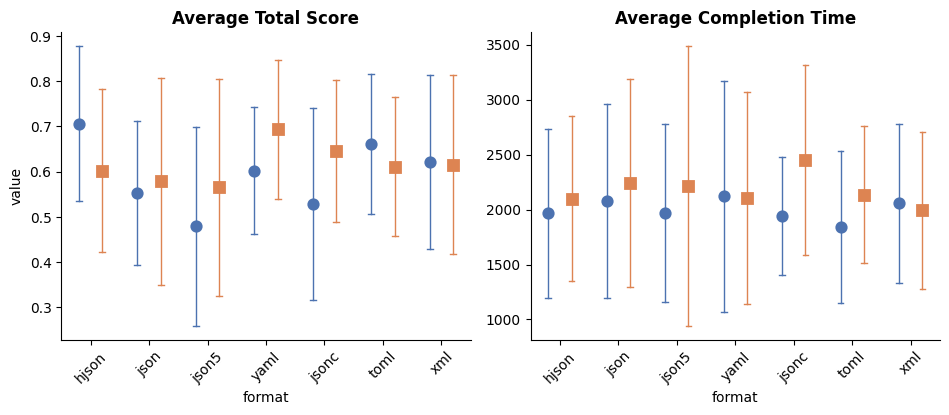

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# —— 假设 df_all 已有 ['format','task','total_score','duration_sec_total'] —— #

# 把两个指标 melt 到同一张表
df_melt = pd.melt(
    df_merged,
    id_vars=['format','task'],
    value_vars=['total_score', 'duration_sec_total'],
    var_name='metric',
    value_name='value'
)

formats    = sorted(df_all['format'].unique())
markers    = ['o','s','^','D','P','X','*']
marker_map = dict(zip(formats, markers))
palette    = {'tabular':'#4C72B0', 'config':'#DD8452'}
title_map  = {
    'total_score'        : "Average Total Score",
    'duration_sec_total' : "Average Completion Time"
}

# —— 用 catplot 画 FacetGrid + pointplot —— #
g = sns.catplot(
    data       = df_melt,
    x          = 'format',
    y          = 'value',
    hue        = 'task',
    col        = 'metric',
    kind       = 'point',
    dodge      = 0.4,
    ci         = 'sd',
    errwidth   = 1,
    capsize    = 0.1,
    palette    = palette,
    markers    = ['o','s'],    # 只给 hue=task 两个 marker
    join       = False,        # 不画线
    legend     = False,        # 先不要自动 legend
    height     = 4,
    aspect     = 1.2,
    sharey     = False
)

# —— 调整每个子图 —— #
for ax in g.axes.flat:
    # 1) 旋转 x 轴标签
    ax.tick_params(axis='x', labelrotation=45)

    # 2) 把标题 "metric = total_score" → "Average Total Score"
    raw = ax.get_title().split('=')[-1].strip()   # 要 strip() 去掉空格！
    ax.set_title(title_map[raw], fontweight='bold')

    # 3) 删除 seaborn 自动创建的 legend（如果有的话）
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# —— 最后在整张 Figure 上加一个 legend —— #
# (1) color=task 的 handles
task_handles = [
    Line2D([0],[0], marker='o', color='w', label='tabular',
           markerfacecolor=palette['tabular'], markersize=8, edgecolor='k'),
    Line2D([0],[0], marker='o', color='w', label='config',
           markerfacecolor=palette['config'], markersize=8, edgecolor='k'),
]
# (2) shape=format 的 handles
fmt_handles = [
    Line2D([0],[0], marker=marker_map[f], color='k', label=f,
           linestyle='None', markersize=8)
    for f in formats
]

# 用 fig.legend 而非 plt.legend，放在外面
g.fig.legend(
    handles    = task_handles + fmt_handles,
    title      = "Color = Task / Shape = Format",
    bbox_to_anchor=(1.05, 1),
    loc        ='upper left'
)

plt.tight_layout()
plt.show()


/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_55413/3226921957.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_fmt.set_xticklabels(ax_fmt.get_xticklabels(), rotation=45)
/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_55413/3226921957.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


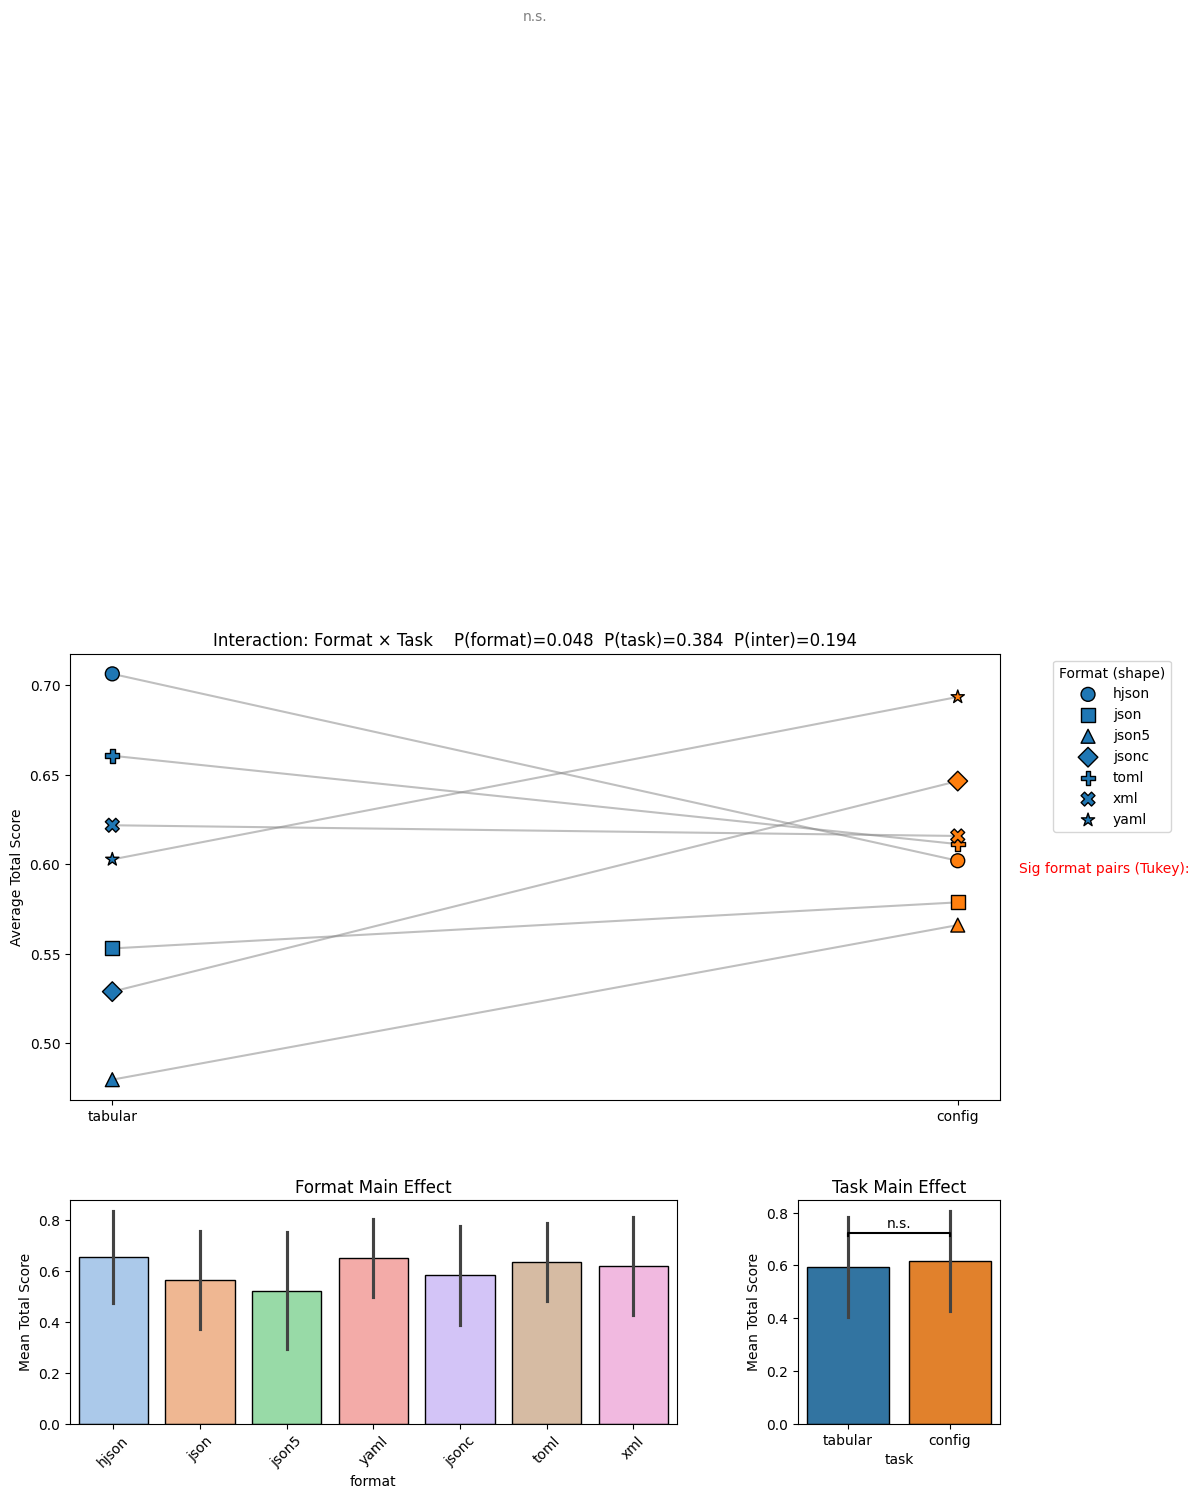

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from matplotlib.lines import Line2D

# === 1. 假设你已构造好 df_all，包含 ['participantId','format','task','total_score'] === #

# ---- Two‑way ANOVA ----
model = ols('total_score ~ C(format) * C(task)', data=df_all).fit()
anova = sm.stats.anova_lm(model, typ=2)
p_format      = anova.loc['C(format)',      'PR(>F)']
p_task        = anova.loc['C(task)',        'PR(>F)']
p_interaction = anova.loc['C(format):C(task)','PR(>F)']

# ---- Tukey HSD for format ----
tukey   = pairwise_tukeyhsd(df_all['total_score'], df_all['format'], alpha=0.05)
tk_df   = pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])
sig_fmt = tk_df[tk_df['p-adj']<0.05][['group1','group2','p-adj']]

# ---- t-test for task ----
tab_scores = df_all[df_all['task']=='tabular']['total_score']
cfg_scores = df_all[df_all['task']=='config']['total_score']
t_stat, p_task_ttest = ttest_ind(tab_scores, cfg_scores, equal_var=False)

# === 2. 布局 subplots === #
fig = plt.figure(figsize=(12,10))
gs  = fig.add_gridspec(2, 2, height_ratios=[2,1], width_ratios=[3,1], hspace=0.3, wspace=0.3)

ax_int = fig.add_subplot(gs[0,:])   # 上排：interaction 跨两列
ax_fmt = fig.add_subplot(gs[1,0])  # 下排左：format 主效应
ax_task= fig.add_subplot(gs[1,1])  # 下排右：task 主效应

# === 3. Interaction Plot === #
formats    = sorted(df_all['format'].unique())
markers    = ['o','s','^','D','P','X','*']
marker_map = dict(zip(formats, markers))
color_map  = {'tabular':'C0','config':'C1'}

# 先 plot lines+points
for fmt in formats:
    sub = df_all[df_all['format']==fmt].groupby('task')['total_score'].mean()
    x = [0,1]  # 0=tabular,1=config
    y = [sub['tabular'], sub['config']]
    ax_int.plot(x, y, color='gray', alpha=0.5, zorder=1)
    ax_int.scatter(
        x, y,
        c=[color_map['tabular'],color_map['config']],
        marker=marker_map[fmt],
        s=100, edgecolor='k', zorder=2,
        label=fmt if fmt not in ax_int.get_legend_handles_labels()[1] else ""
    )

ax_int.set_xticks([0,1]); ax_int.set_xticklabels(['tabular','config'])
ax_int.set_ylabel("Average Total Score")
ax_int.set_title(
    f"Interaction: Format × Task    "
    f"P(format)={p_format:.3f}  P(task)={p_task:.3f}  P(inter)={p_interaction:.3f}"
)

# 标注 Tukey 显著格式对
txt_fmt = "Sig format pairs (Tukey):\n" + \
    "\n".join([f"{a} vs {b} (p={p:.3f})" for a,b,p in sig_fmt.values])
ax_int.text(1.02, 0.5, txt_fmt, transform=ax_int.transAxes,
            fontsize=10, color='red', va='center')

# 标注任务差异 bracket
ymax = df_all['total_score'].max() + 0.05
if p_task_ttest < 0.05:
    ax_int.plot([0,0,1,1], [ymax,ymax+0.01,ymax+0.01,ymax], color='k')
    ax_int.text(0.5, ymax+0.02, "*", ha='center', va='bottom', color='k')
else:
    ax_int.text(0.5, ymax+0.02, "n.s.", ha='center', va='bottom', color='gray')

ax_int.legend(title="Format (shape)", bbox_to_anchor=(1.05,1), loc='upper left')

# === 4. Format 主效应 Barplot === #
sns.barplot(
    data=df_all, x='format', y='total_score',
    ci='sd', ax=ax_fmt, palette='pastel', edgecolor='k'
)
ax_fmt.set_xticklabels(ax_fmt.get_xticklabels(), rotation=45)
ax_fmt.set_ylabel("Mean Total Score")
ax_fmt.set_title("Format Main Effect")

# 在显著的格式对上画星号
means = df_all.groupby('format')['total_score'].mean()
y_base = means.max() + df_all['total_score'].std()*0.5
offset = df_all['total_score'].std()*0.3
for i,(a,b,p) in enumerate(sig_fmt.values):
    xi, xj = formats.index(a), formats.index(b)
    y = y_base + i*offset
    ax_fmt.plot([xi, xi, xj, xj], [y, y+0.01, y+0.01, y], color='k')
    ax_fmt.text((xi+xj)/2, y+0.02, "*", ha='center', va='bottom')

# === 5. Task 主效应 Barplot === #
sns.barplot(
    data=df_all, x='task', y='total_score',
    ci='sd', ax=ax_task, palette=['C0','C1'], edgecolor='k'
)
ax_task.set_ylabel("Mean Total Score")
ax_task.set_title("Task Main Effect")

# 画タスク差异 bracket
mtab = tab_scores.mean(); mcfg = cfg_scores.mean()
y_task = max(mtab, mcfg) + df_all['total_score'].std()*0.5
ax_task.plot([0,0,1,1], [y_task, y_task+0.01, y_task+0.01, y_task], color='k')
ax_task.text(0.5, y_task+0.02, "*" if p_task_ttest<0.05 else "n.s.",
             ha='center', va='bottom', color='k')

plt.tight_layout()
plt.show()


In [29]:
df_merged

,participantId,format,total_score,task,duration_sec_total
0,56cb8858edf8da000b6df354,hjson,0.742656,tabular,899.197
1,57c357770e6a1f00015f6038,json,0.535604,tabular,951.163
2,5b68c9eb87af310001584803,json5,0.403386,tabular,901.443
3,5c6414540821d30001046198,hjson,0.626937,tabular,2613.853
4,5d30dfa68b1523000134878f,json,0.723415,tabular,1574.851
...,...,...,...,...,...
207,680ebf035ab59d342f31726e,hjson,0.863388,config,2457.674
208,681374d36d7bd7ccb6f914f5,json5,0.914926,config,737.711
209,68138e7f96395f4c5f3a0a87,json,0.375435,config,1319.207
210,6818ca1523ece90f671e3601,json,0.432629,config,2413.983


Columns: ['participantId', 'format', 'total_score', 'task', 'duration_sec_total', 'rank_score', 'rank_duration']


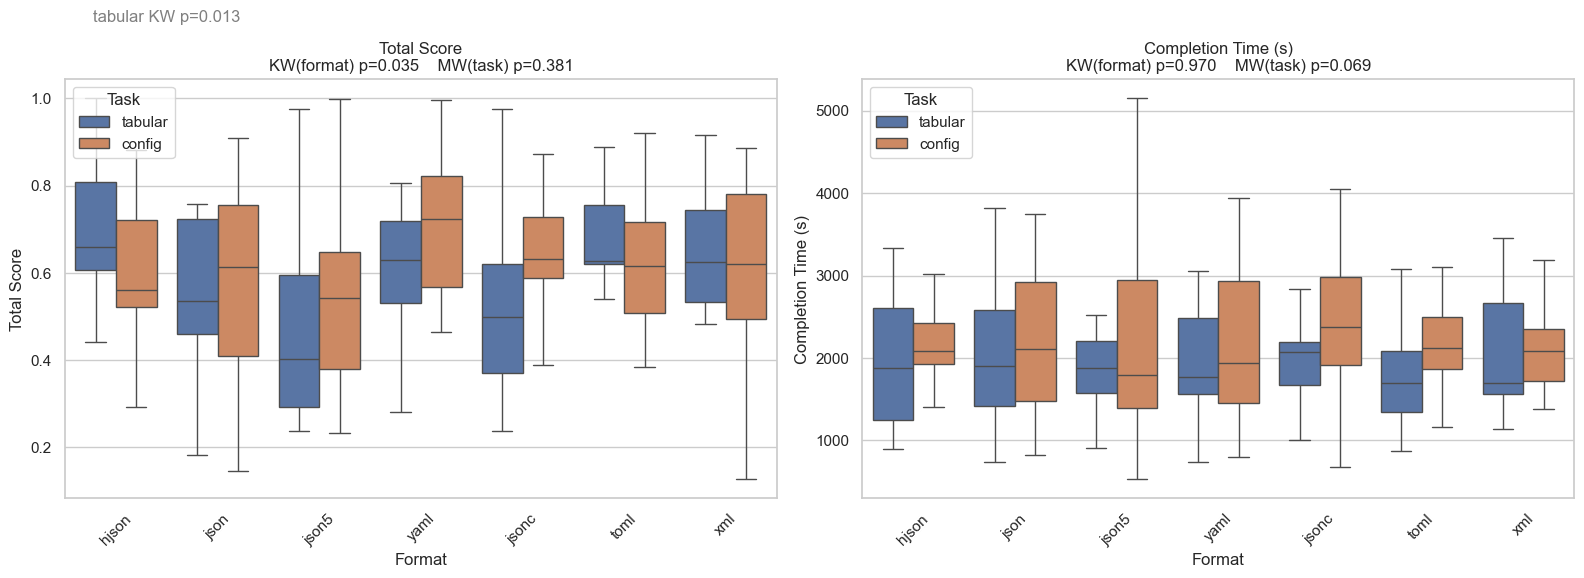

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from matplotlib.lines import Line2D

# ————————————————————————————————————————————————————————————————
# 前提：df_merged 已有列
# ['participantId','format','task','total_score','duration_sec_total']
# ————————————————————————————————————————————————————————————————
print("Columns:", df_merged.columns.tolist())

metrics = ['total_score', 'duration_sec_total']
formats = sorted(df_merged['format'].unique())
tasks   = ['tabular','config']
palette = {'tabular':'#4C72B0','config':'#DD8452'}

# — 存放结果 ——————————————————————————————————————————————————
# 1) 主效应（格式×所有任务, 任务×所有格式）
kw_p        = {}  # Kruskal–Wallis for format over both tasks
mw_p        = {}  # Mann–Whitney for task over both formats
posthoc_fmt = {}  # format两两（全局）
posthoc_tsk = {}  # task两两（全局，仅一对）
# 2) 简单效应（交叉检验）
#    a) 任务内部：对每个格式做 tabular vs config
simple_task = {met:{} for met in metrics}
#    b) 格式内部：对每个任务做格式之间的 KW + posthoc
simple_format = {met:{} for met in metrics}

# ————————————————————————————————————————————————————————————————
# 全局检验 & posthoc
for met in metrics:
    # 格式主效应：Kruskal–Wallis (pool tasks)
    groups_fmt = [df_merged[df_merged['format']==f][met] for f in formats]
    kw_stat, kwp = kruskal(*groups_fmt)
    kw_p[met] = kwp

    # 任务主效应：Mann–Whitney (pool formats)
    tab = df_merged[df_merged['task']=='tabular'][met]
    cfg = df_merged[df_merged['task']=='config'][met]
    _, mwp = mannwhitneyu(tab, cfg, alternative='two-sided')
    mw_p[met] = mwp

    # posthoc 格式两两
    pairs = list(combinations(formats,2))
    pvals = []
    for a,b in pairs:
        xa = df_merged[df_merged['format']==a][met]
        xb = df_merged[df_merged['format']==b][met]
        _, p = mannwhitneyu(xa, xb, alternative='two-sided')
        pvals.append(p)
    rej, p_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    posthoc_fmt[met] = [(pairs[i][0], pairs[i][1], p_fdr[i])
                        for i in range(len(pairs)) if rej[i]]

    # posthoc 任务（只有 tabular vs config 这对）
    posthoc_tsk[met] = [('tabular','config', mw_p[met])]

# ————————————————————————————————————————————————————————————————
# 交叉检验：简单效应
for met in metrics:
    # a) 任务内部：对每个格式做 tabular vs config
    pvals = []
    fmts  = []
    for f in formats:
        xa = df_merged[(df_merged['format']==f)&(df_merged['task']=='tabular')][met]
        xb = df_merged[(df_merged['format']==f)&(df_merged['task']=='config')][met]
        if len(xa)>0 and len(xb)>0:
            _, p = mannwhitneyu(xa, xb, alternative='two-sided')
        else:
            p = np.nan
        pvals.append(p); fmts.append(f)
    rej, p_fdr, _, _ = multipletests([p for p in pvals if not np.isnan(p)],
                                     alpha=0.05, method='fdr_bh')
    # 把校正后结果填回
    idx=0
    for i,f in enumerate(fmts):
        if not np.isnan(pvals[i]):
            simple_task[met][f] = p_fdr[idx] if rej[idx] else np.nan
            idx+=1
        else:
            simple_task[met][f] = np.nan

    # b) 格式内部：每个任务做格式之间的 KW + posthoc
    for t in tasks:
        df_sub = df_merged[df_merged['task']==t]
        groups = [df_sub[df_sub['format']==f][met] for f in formats]
        if all(len(g)>0 for g in groups):
            stat,p = kruskal(*groups)
            kw_sub_p = p
        else:
            kw_sub_p = np.nan
        # posthoc
        pairs = list(combinations(formats,2))
        pvals = []
        for a,b in pairs:
            xa = df_sub[df_sub['format']==a][met]
            xb = df_sub[df_sub['format']==b][met]
            if len(xa)>0 and len(xb)>0:
                _, p = mannwhitneyu(xa, xb, alternative='two-sided')
            else:
                p = np.nan
            pvals.append(p)
        # FDR
        valid = ~np.isnan(pvals)
        rej, p_fdr, _, _ = multipletests(np.array(pvals)[valid],
                                         alpha=0.05, method='fdr_bh')
        # 收集
        sigs = []
        idx2 = 0
        for j,(a,b) in enumerate(pairs):
            if valid[j]:
                if rej[idx2]:
                    sigs.append((a,b,p_fdr[idx2]))
                idx2+=1
        simple_format[met][t] = {'kw_p':kw_sub_p, 'posthoc':sigs}

# ————————————————————————————————————————————————————————————————
# 可视化：箱线图 + 标注
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=False)

for ax, met in zip(axes, metrics):
    sns.boxplot(data=df_merged, x='format', y=met, hue='task',
                ax=ax, palette=palette, showfliers=False)
    # 全局主效应标题
    ax.set_title(
        f"{titles[met]}\n"
        f"KW(format) p={kw_p[met]:.3f}    MW(task) p={mw_p[met]:.3f}"
    )
    ax.set_xlabel("Format"); ax.set_ylabel(titles[met])
    ax.tick_params(axis='x', rotation=45)

    # 标注全局格式 posthoc
    y0 = df_merged[met].max(); rng = y0 - df_merged[met].min()
    for i,(a,b,p) in enumerate(posthoc_fmt[met]):
        xa, xb = formats.index(a), formats.index(b)
        y_line = y0 + rng*0.05*(i+1)
        ax.plot([xa,xa, xb,xb], [y_line,y_line+0.02*rng,y_line+0.02*rng,y_line], 'k-')
        ax.text((xa+xb)/2, y_line+0.03*rng, "*", ha='center')

    # 标注全局任务 posthoc（tab vs cfg）
    if mw_p[met] < 0.05:
        yb = y0 + rng*0.05*(len(posthoc_fmt[met])+2)
        ax.plot([-0.4,-0.4,1.4,1.4],[yb,yb+0.02*rng,yb+0.02*rng,yb],'k-')
        ax.text(0.5, yb+0.03*rng, "*", ha='center')

    # 标注简单效应：任务内部
    for j, f in enumerate(formats):
        p = simple_task[met][f]
        if not np.isnan(p):
            if p < 0.05:
                # 画在该格式两箱子中点上方
                x0 = j-0.2; x1 = j+0.2
                y = df_merged[(df_merged['format']==f)][met].max() + rng*0.02
                ax.plot([x0,x0,x1,x1],[y,y+0.01*rng,y+0.01*rng,y],'k-')
                ax.text(j, y+0.02*rng, "*", ha='center')

    # 标注简单效应：格式内部
    offset = len(posthoc_fmt[met]) + 4
    for k, t in enumerate(tasks):
        info = simple_format[met][t]
        if not np.isnan(info['kw_p']) and info['kw_p']<0.05:
            # 文字标注该任务内部KW p
            ax.text(0.5, y0 + rng*0.05*(offset+k), f"{t} KW p={info['kw_p']:.3f}",
                    ha='center', color='gray')

    # 精简图例：只保留 Task
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[:2], l[:2], title="Task", loc='upper left')

plt.tight_layout()
plt.show()



=== SRH approx for total_score ===
                           sum_sq     df         F    PR(>F)
C(format)           50588.127897    6.0  2.349684  0.032494
C(task)              2445.135428    1.0  0.681420  0.410092
C(format):C(task)   30030.045477    6.0  1.394815  0.218361
Residual           710482.139978  198.0       NaN       NaN

=== SRH approx for duration_sec_total ===
                           sum_sq     df         F    PR(>F)
C(format)            5558.926869    6.0  0.238894  0.963218
C(task)             13059.185806    1.0  3.367303  0.068003
C(format):C(task)    8056.246319    6.0  0.346216  0.911501
Residual           767890.257875  198.0       NaN       NaN

Significant format pairs for total_score (MWU+FDR):
 []

Significant format pairs for duration_sec_total (MWU+FDR):
 []
Task p for total_score: 0.381
Task p for duration_sec_total: 0.069


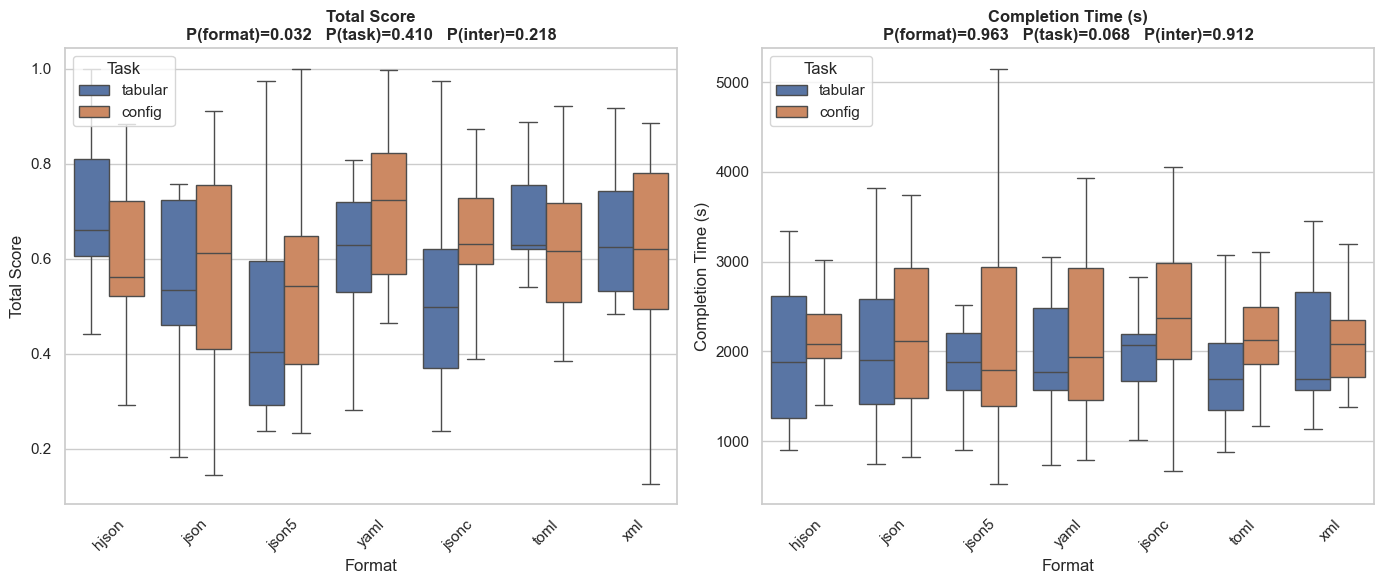

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from matplotlib.lines import Line2D

# ─────────────────────────────────────────────────────────────────────────────
# 前提：df_merged 已存在并包含列：
#   ['participantId','format','task','total_score','duration_sec_total']
# ─────────────────────────────────────────────────────────────────────────────

# 1) 秩变换
df_merged['rank_score']    = df_merged['total_score'].rank()
df_merged['rank_duration'] = df_merged['duration_sec_total'].rank()

# 2) Rank‐Based ANOVA (Scheirer–Ray–Hare 近似)
anova_srh = {}
for met, rankcol in [('total_score','rank_score'),
                     ('duration_sec_total','rank_duration')]:
    model = ols(f"{rankcol} ~ C(format)*C(task)", data=df_merged).fit()
    aov   = sm.stats.anova_lm(model, typ=2)
    anova_srh[met] = aov
    print(f"\n=== SRH approx for {met} ===\n", aov)

# 3) 事后两两比较：格式两两 Mann–Whitney U + FDR
formats = sorted(df_merged['format'].unique())
post_fmt = {}
for met in ['total_score','duration_sec_total']:
    pairs = list(combinations(formats, 2))
    pvals = []
    for a,b in pairs:
        da = df_merged[df_merged['format']==a][met]
        db = df_merged[df_merged['format']==b][met]
        _, p = mannwhitneyu(da, db, alternative='two-sided')
        pvals.append(p)
    # FDR 校正
    reject, p_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    post_fmt[met] = [(pairs[i][0], pairs[i][1], p_fdr[i])
                     for i in range(len(pairs)) if reject[i]]
    print(f"\nSignificant format pairs for {met} (MWU+FDR):\n", post_fmt[met])

# 4) Task 主效应：Mann–Whitney U
p_task = {}
for met in ['total_score','duration_sec_total']:
    tab = df_merged[df_merged['task']=='tabular'][met]
    cfg = df_merged[df_merged['task']=='config'][met]
    _, p = mannwhitneyu(tab, cfg, alternative='two-sided')
    p_task[met] = p
    print(f"Task p for {met}: {p:.3f}")

# 5) 可视化：箱线图 + 显著性标注
sns.set(style="whitegrid")
palette = {'tabular':'#4C72B0','config':'#DD8452'}
titles  = {'total_score':"Total Score", 
           'duration_sec_total':"Completion Time (s)"}

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

for ax, met in zip(axes, ['total_score','duration_sec_total']):
    # 箱线图
    sns.boxplot(data=df_merged, x='format', y=met, hue='task',
                ax=ax, palette=palette, showfliers=False)
    # 标题写 SRH p 值
    aov = anova_srh[met]
    ax.set_title(
        f"{titles[met]}\n"
        f"P(format)={aov.loc['C(format)','PR(>F)']:.3f}   "
        f"P(task)={aov.loc['C(task)','PR(>F)']:.3f}   "
        f"P(inter)={aov.loc['C(format):C(task)','PR(>F)']:.3f}",
        fontweight='bold'
    )
    ax.set_xlabel("Format")
    ax.set_ylabel(titles[met])
    ax.tick_params(axis='x', rotation=45)

    # 5.1 标注格式两两显著对
    sigs = post_fmt[met]
    y0   = df_merged[met].max()
    rng  = y0 - df_merged[met].min()
    for i, (a,b,p) in enumerate(sigs):
        xa, xb = formats.index(a), formats.index(b)
        y_line = y0 + rng*0.05*(i+1)
        ax.plot([xa,xa, xb,xb], 
                [y_line, y_line+0.02*rng, y_line+0.02*rng, y_line],
                'k-')
        ax.text((xa+xb)/2, y_line+0.03*rng, "*", ha='center')

    # 5.2 如果 Task 差异显著，画 bracket＋星号
    if p_task[met] < 0.05:
        yb = y0 + rng*0.05*(len(sigs)+2)
        ax.plot([-0.4,-0.4, len(formats)-0.6, len(formats)-0.6],
                [yb, yb+0.02*rng, yb+0.02*rng, yb], 'k-')
        ax.text((len(formats)-0.6-0.4)/2, yb+0.03*rng, "*", ha='center')

    # 5.3 精简图例：只保留 Task 色块
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Task", loc='upper left')

plt.tight_layout()
plt.show()


Columns: ['participantId', 'format', 'total_score', 'task', 'duration_sec_total', 'rank_score', 'rank_duration']


 ======================================== total_score ========================================
 omnibus p-values → format=0.037, task=0.191, interaction=0.164

Tukey HSD for format:


/Users/shiyi.he/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/shiyi.he/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/shiyi.he/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/shiyi.he/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarni

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 hjson   json  -0.0909 0.4598 -0.2308  0.049  False
 hjson  json5  -0.1331 0.0829 -0.2753  0.009  False
 hjson  jsonc  -0.0725   0.75 -0.2172 0.0723  False
 hjson   toml  -0.0199 0.9996 -0.1621 0.1222  False
 hjson    xml  -0.0372 0.9873 -0.1806 0.1062  False
 hjson   yaml  -0.0049    1.0 -0.1448  0.135  False
  json  json5  -0.0422 0.9735 -0.1833 0.0988  False
  json  jsonc   0.0184 0.9998 -0.1252 0.1621  False
  json   toml    0.071 0.7458 -0.0701  0.212  False
  json    xml   0.0537 0.9202 -0.0886  0.196  False
  json   yaml    0.086 0.5195 -0.0528 0.2247  False
 json5  jsonc   0.0607 0.8782 -0.0852 0.2065  False
 json5   toml   0.1132 0.2248 -0.0301 0.2565  False
 json5    xml   0.0959 0.4328 -0.0486 0.2405  False
 json5   yaml   0.1282 0.1019 -0.0129 0.2693  False
 jsonc   toml   0.0525 0.9355 -0.0933 0.1984  False
 jsonc    xm

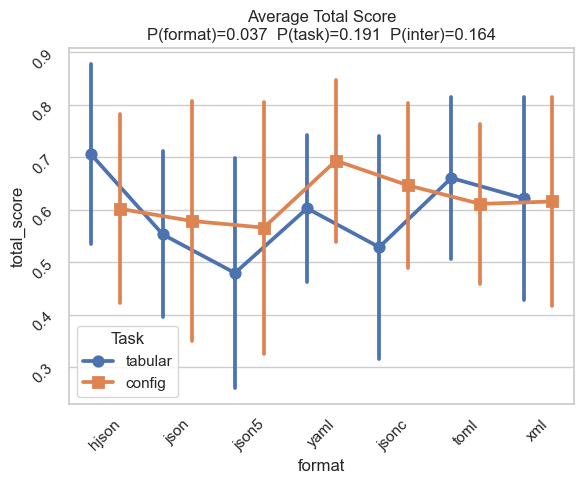



 ======================================== duration_sec_total ========================================
 omnibus p-values → format=0.986, task=0.683, interaction=0.877

Tukey HSD for format:


/Users/shiyi.he/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/shiyi.he/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/shiyi.he/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/shiyi.he/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarni

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
 hjson   json  124.1345 0.9972 -509.8158 758.0847  False
 hjson  json5   58.6901    1.0 -585.5743 702.9546  False
 hjson  jsonc  147.1035 0.9942 -508.7501  802.957  False
 hjson   toml  -44.1595    1.0  -688.424 600.1049  False
 hjson    xml   -7.5872    1.0 -657.4722 642.2978  False
 hjson   yaml   80.8007 0.9998 -553.1495 714.7509  False
  json  json5  -65.4443 0.9999 -704.7388 573.8501  False
  json  jsonc    22.969    1.0 -628.0031  673.941  False
  json   toml  -168.294 0.9863 -807.5885 471.0005  False
  json    xml -131.7217 0.9965   -776.68 513.2366  False
  json   yaml  -43.3338    1.0 -672.2325  585.565  False
 json5  jsonc   88.4133 0.9997 -572.6074 749.4341  False
 json5   toml -102.8497 0.9992 -752.3735 546.6742  False
 json5    xml  -66.2773 0.9999 -721.3766 588.8219  False
 json5   yaml   22.1106    1.0 

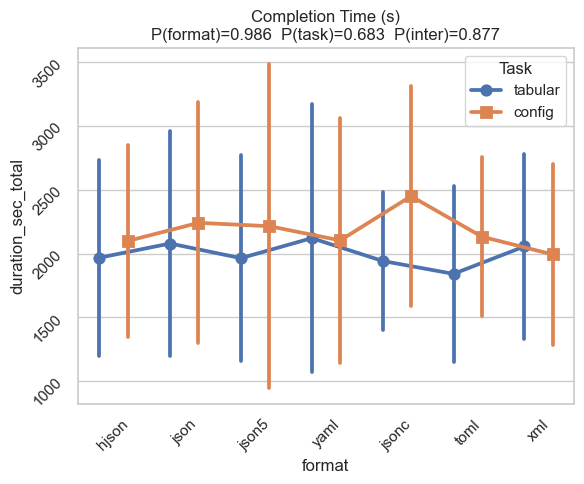

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2
from scipy.stats import ttest_ind
from matplotlib.lines import Line2D

# ——————————————————————————————————————————————————————————————
# 前提：df_merged 已有 ['participantId','format','task',
#                       'total_score','duration_sec_total']
# ——————————————————————————————————————————————————————————————
print("Columns:", df_merged.columns.tolist())

# 映射
formats = sorted(df_merged['format'].unique())
palette = {'tabular':'C0','config':'C1'}
titles  = {'total_score':"Average Total Score",
           'duration_sec_total':"Completion Time (s)"}

def fit_lme(formula):
    """Fit linear mixed model and return the result."""
    return smf.mixedlm(formula, df_merged, groups=df_merged["participantId"]).fit(reml=False)

def lrt_p(full_res, reduced_res):
    """Compute likelihood ratio test p-value."""
    llf_full = full_res.llf
    llf_red  = reduced_res.llf
    lr       = 2 * (llf_full - llf_red)
    df_diff  = full_res.df_modelwc - reduced_res.df_modelwc
    p        = chi2.sf(lr, df_diff)
    return lr, p

def analyze(dv):
    print("\n\n", "="*40, dv, "="*40)
    # 1) Fit full and reduced models
    full     = fit_lme(f"{dv} ~ C(format)*C(task)")
    no_fmt   = fit_lme(f"{dv} ~ C(task)")
    no_task  = fit_lme(f"{dv} ~ C(format)")
    no_int   = fit_lme(f"{dv} ~ C(format) + C(task)")

    # 2) LRT omnibus tests
    _, p_fmt  = lrt_p(full, no_fmt)
    _, p_task = lrt_p(full, no_task)
    _, p_int  = lrt_p(full, no_int)
    print(f" omnibus p-values → format={p_fmt:.3f}, task={p_task:.3f}, interaction={p_int:.3f}")

    # 3) Post‑hoc: format Tukey, task t‑test
    print("\nTukey HSD for format:")
    print(pairwise_tukeyhsd(df_merged[dv], df_merged['format'], alpha=0.05).summary())

    tab = df_merged[df_merged['task']=='tabular'][dv]
    cfg = df_merged[df_merged['task']=='config'][dv]
    tstat, p_t = ttest_ind(tab, cfg, equal_var=False)
    print(f"\nt-test for task: t={tstat:.3f}, p={p_t:.3f}")

    # 4) Simple effects if interaction significant
    if p_int < 0.05:
        print("\nSimple effects (interaction p<.05):")
        # 4a) Within each format: tab vs config
        for f in formats:
            xa = df_merged[(df_merged.format==f)&(df_merged.task=='tabular')][dv]
            xb = df_merged[(df_merged.format==f)&(df_merged.task=='config')][dv]
            _, p2 = ttest_ind(xa, xb, equal_var=False)
            print(f"  {f}: tab vs cfg p={p2:.3f}")
        # 4b) Within each task: Tukey on formats
        for t in ['tabular','config']:
            sub = df_merged[df_merged.task==t]
            print(f"\n  Tukey within {t}:")
            print(pairwise_tukeyhsd(sub[dv], sub['format'], alpha=0.05).summary())

    # 5) Visualization
    fig, ax = plt.subplots(figsize=(6,5))
    sns.pointplot(x='format', y=dv, hue='task', data=df_merged,
                  dodge=0.4, ci='sd', palette=palette,
                  markers=['o','s'], ax=ax)
    ax.set_title(
        f"{titles[dv]}\n"
        f"P(format)={p_fmt:.3f}  P(task)={p_task:.3f}  P(inter)={p_int:.3f}"
    )
    ax.tick_params(rotation=45)
    ax.legend(title="Task", loc='best')
    plt.tight_layout()
    plt.show()

# 对两个指标分别分析
analyze('total_score')
analyze('duration_sec_total')


ANOVA p-values:
                      sum_sq     df         F    PR(>F)
C(format)          0.445147    6.0  2.161588  0.048263
C(task)            0.026091    1.0  0.760161  0.384334
C(format):C(task)  0.300635    6.0  1.459854  0.193814
Residual           6.795856  198.0       NaN       NaN
Significant format pairs (Tukey): []
Formats with significant task differences (FDR): []
Significant format pairs within tabular (Tukey): [['hjson', 'json5']]
Significant format pairs within config (Tukey): []


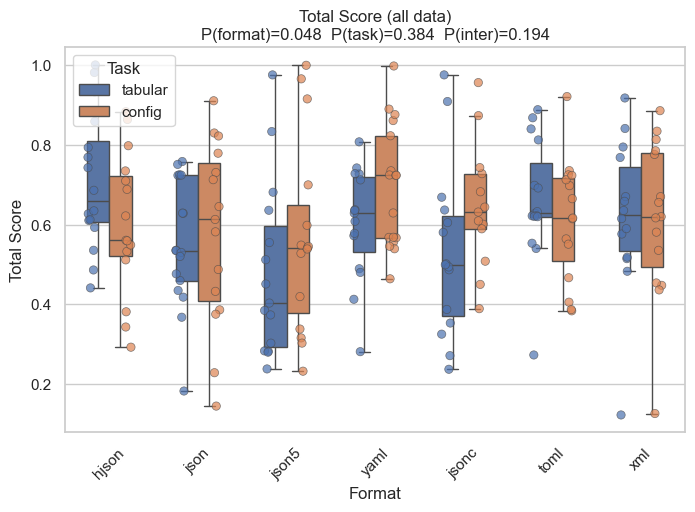

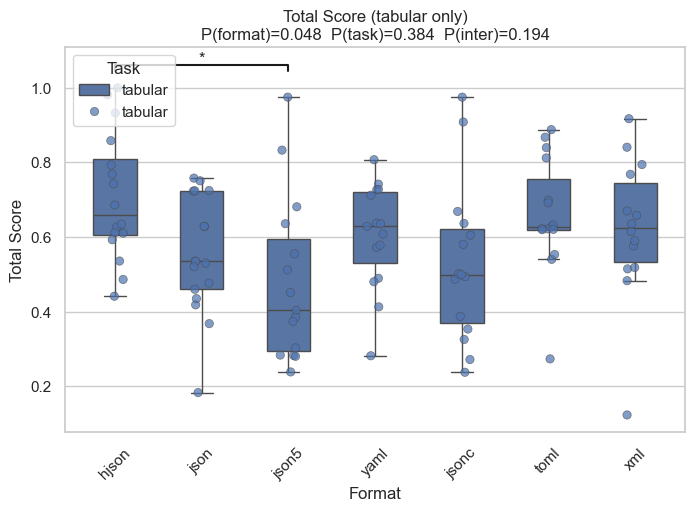

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# —————————————————————————————————————————————————————————————
# 前提：df_merged 包含 ['participantId','format','task','total_score',...]
# —————————————————————————————————————————————————————————————

formats = sorted(df_merged['format'].unique())
palette = {'tabular':'#4C72B0','config':'#DD8452'}

# —— 1) Two‑way ANOVA —— #
model = ols('total_score ~ C(format)*C(task)', data=df_merged).fit()
aov   = sm.stats.anova_lm(model, typ=2)
p_fmt = aov.loc['C(format)',       'PR(>F)']
p_tsk = aov.loc['C(task)',         'PR(>F)']
p_int = aov.loc['C(format):C(task)','PR(>F)']

print("ANOVA p-values:\n", aov)

# —— 2) 全局 Tukey HSD for format —— #
tukey = pairwise_tukeyhsd(
    endog = df_merged['total_score'],
    groups= df_merged['format'],
    alpha = 0.05
)
tk_df = pd.DataFrame(tukey.summary().data[1:], 
                     columns=tukey.summary().data[0])
sig_fmt_pairs = tk_df[tk_df['reject']==True][['group1','group2']].values.tolist()
print("Significant format pairs (Tukey):", sig_fmt_pairs)

# —— 3) 简单效应：在每个格式下比较任务 —— #
p_vals = []
for fmt in formats:
    g0 = df_merged[(df_merged['format']==fmt)&(df_merged['task']=='tabular')]['total_score']
    g1 = df_merged[(df_merged['format']==fmt)&(df_merged['task']=='config')]['total_score']
    _, p = ttest_ind(g0, g1, equal_var=False)
    p_vals.append(p)

# FDR 校正
rej, p_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
sig_task_within_fmt = [formats[i] for i,r in enumerate(rej) if r]
print("Formats with significant task differences (FDR):", sig_task_within_fmt)

# —— 4) 简单效应：在每个任务下比较格式 —— #
sig_fmt_within_task = {}
for task in ['tabular','config']:
    sub = df_merged[df_merged['task']==task]
    tk2 = pairwise_tukeyhsd(endog=sub['total_score'],
                            groups=sub['format'], alpha=0.05)
    df2 = pd.DataFrame(tk2.summary().data[1:], columns=tk2.summary().data[0])
    sigs = df2[df2['reject']==True][['group1','group2']].values.tolist()
    sig_fmt_within_task[task] = sigs
    print(f"Significant format pairs within {task} (Tukey):", sigs)

# —— 5) 可视化函数 —— #
def plot_score(data, title_suffix, sig_fmt, sig_task_fmt):
    fig, ax = plt.subplots(figsize=(8,5))
    # 瘦箱线
    sns.boxplot(
        data = data, x='format', y='total_score', hue='task',
        palette=palette, width=0.5, showfliers=False, ax=ax
    )
    # 散点抖动
    sns.stripplot(
        data = data, x='format', y='total_score', hue='task',
        palette=palette, dodge=True, size=6, alpha=0.7,
        edgecolor='gray', linewidth=0.5, ax=ax
    )
    # 只留一套图例
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Task", loc='upper left')

    # 标题
    ax.set_title(
        f"Total Score{title_suffix}\n"
        f"P(format)={p_fmt:.3f}  "
        f"P(task)={p_tsk:.3f}  "
        f"P(inter)={p_int:.3f}"
    )
    ax.set_xlabel("Format")
    ax.set_ylabel("Total Score")
    ax.tick_params(axis='x', rotation=45)

    # 准备画连线的 y 起点
    y0  = data['total_score'].max()
    rng = y0 - data['total_score'].min()
    base = y0 + 0.05*rng

    # (a) 全局格式显著对
    for i,(a,b) in enumerate(sig_fmt):
        x1, x2 = formats.index(a), formats.index(b)
        y = base + i*0.05*rng
        ax.plot([x1,x1,x2,x2],
                [y,y+0.02*rng,y+0.02*rng,y],
                'k-')
        ax.text((x1+x2)/2, y+0.025*rng, '*', ha='center')

    # (b) 简单效应：任务差异显著的格式
    for j,fmt in enumerate(formats):
        if fmt in sig_task_fmt:
            x0, x1 = j-0.2, j+0.2
            y = data[data['format']==fmt]['total_score'].max() + 0.015*rng
            ax.plot([x0,x0,x1,x1],
                    [y,y+0.01*rng,y+0.01*rng,y],
                    'k-')
            ax.text(j, y+0.02*rng, '*', ha='center')

    return fig, ax

# —— 5a) 全量数据可视化 —— #
fig1,_ = plot_score(
    df_merged,
    title_suffix=" (all data)",
    sig_fmt        = sig_fmt_pairs,
    sig_task_fmt  = sig_task_within_fmt
)

# —— 5b) 仅表格任务可视化 —— #
fig2,_ = plot_score(
    df_merged[df_merged['task']=='tabular'],
    title_suffix=" (tabular only)",
    sig_fmt        = sig_fmt_within_task['tabular'],
    sig_task_fmt   = []     # 内部只比较任务，没有意义
)

plt.show()


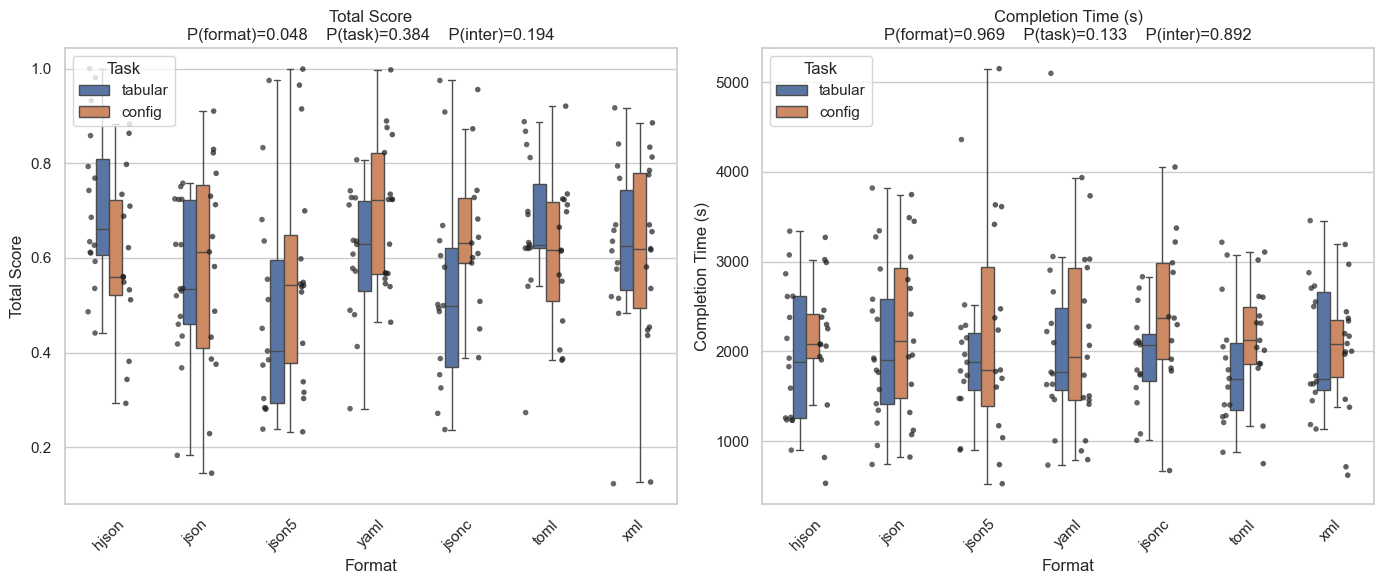

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# — 前提：df_merged 已包含 ['participantId','format','task',
#                              'total_score','duration_sec_total']

formats = sorted(df_merged['format'].unique())
palette = {'tabular':'C0','config':'C1'}
metrics = ['total_score','duration_sec_total']
titles  = {'total_score':"Total Score", 
           'duration_sec_total':"Completion Time (s)"}

# 1) Two‑way ANOVA for each metric
anova_p = {}
for met in metrics:
    m = ols(f"{met} ~ C(format)*C(task)", data=df_merged).fit()
    a = sm.stats.anova_lm(m, typ=2)
    anova_p[met] = {
      'format': a.loc['C(format)','PR(>F)'],
      'task':   a.loc['C(task)','PR(>F)'],
      'inter':  a.loc['C(format):C(task)','PR(>F)']
    }

# 2) Global Tukey HSD for format
tukey_res = {}
for met in metrics:
    tk = pairwise_tukeyhsd(df_merged[met], df_merged['format'], alpha=0.05)
    df_tk = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
    # keep only significant pairs with p‑adj
    sig = df_tk[df_tk['p-adj']<0.05][['group1','group2','p-adj']]
    tukey_res[met] = sig

# 3) Simple effects: within‐format task‐tests + FDR
simple_task = {}
for met in metrics:
    pvals = []
    for f in formats:
        g0 = df_merged[(df_merged['format']==f)&(df_merged['task']=='tabular')][met]
        g1 = df_merged[(df_merged['format']==f)&(df_merged['task']=='config')][met]
        _, p = ttest_ind(g0, g1, equal_var=False)
        pvals.append(p)
    rej, p_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    # map format to corrected p (only those rejected)
    simple_task[met] = {
        f: p_fdr[i] for i,f in enumerate(formats) if rej[i]
    }

# 4) 绘图
sns.set(style="whitegrid")
fig, axes = plt.subplots(1,2,figsize=(14,6),sharey=False)

for ax, met in zip(axes, metrics):
    data = df_merged
    # 瘦箱线
    sns.boxplot(
        data=data, x='format', y=met, hue='task',
        palette=palette, width=0.3, showfliers=False, ax=ax
    )
    # 黑点抖动
    sns.stripplot(
        data=data, x='format', y=met, hue='task',
        color='k', dodge=True, size=4,
        edgecolor='none', alpha=0.7, ax=ax
    )
    # 精简图例
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Task", loc='upper left')

    # 标题写 ANOVA p‑values
    p = anova_p[met]
    ax.set_title(
        f"{titles[met]}\n"
        f"P(format)={p['format']:.3f}    "
        f"P(task)={p['task']:.3f}    "
        f"P(inter)={p['inter']:.3f}"
    )
    ax.set_xlabel("Format")
    ax.set_ylabel(titles[met])
    ax.tick_params(axis='x', rotation=45)

    # 计算基础 y 值
    y_min, y_max = data[met].min(), data[met].max()
    rng = y_max - y_min
    base = y_max + 0.04*rng

    # (A) 全局格式显著对
    for i, row in tukey_res[met].iterrows():
        a,b,pval = row['group1'], row['group2'], row['p-adj']
        x1, x2 = formats.index(a), formats.index(b)
        y = base + i*0.06*rng
        ax.plot([x1,x1,x2,x2],[y,y+0.02*rng,y+0.02*rng,y],'k-')
        ax.text((x1+x2)/2, y+0.025*rng, f"p={pval:.3f}", ha='center')

    # (B) 简单效应：task 内差异的 format
    for j,f in enumerate(formats):
        if f in simple_task[met]:
            pval = simple_task[met][f]
            x0, x1 = j-0.2, j+0.2
            y2 = data[data['format']==f][met].max() + 0.02*rng
            ax.plot([x0,x0,x1,x1],[y2,y2+0.015*rng,y2+0.015*rng,y2],'k-')
            ax.text(j, y2+0.02*rng, f"p={pval:.3f}", ha='center')

plt.tight_layout()
plt.show()


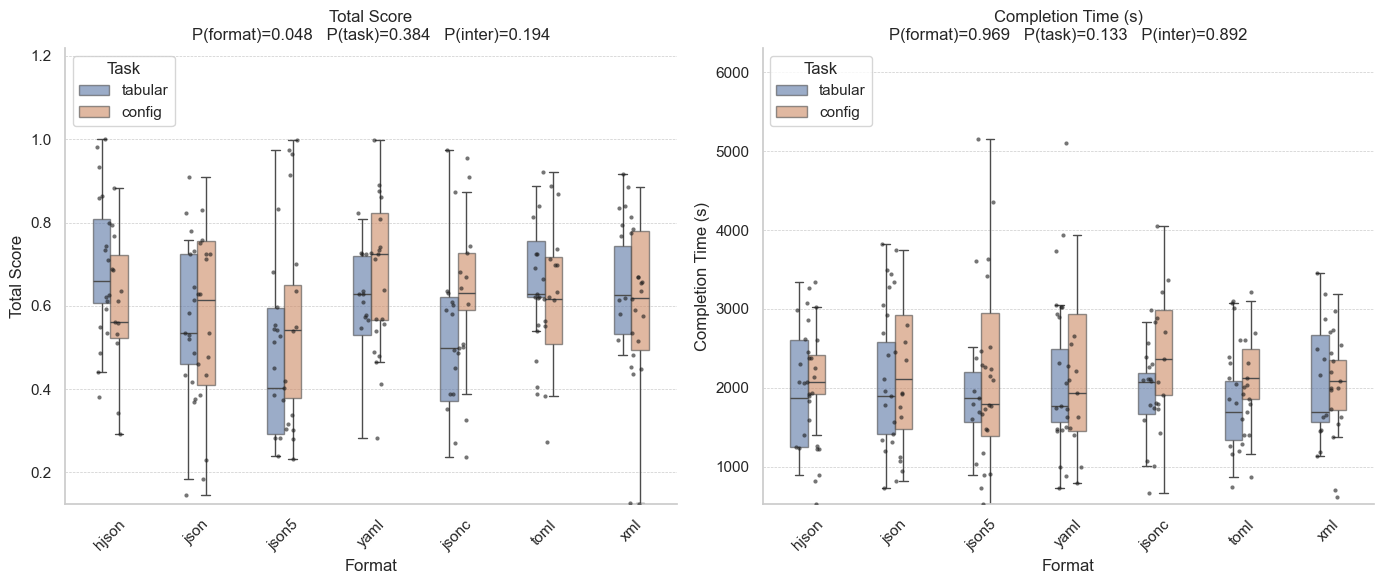

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kruskal
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

formats = sorted(df_merged['format'].unique())
palette = {'tabular':'C0','config':'C1'}
metrics = ['total_score','duration_sec_total']
titles  = {'total_score':"Total Score", 'duration_sec_total':"Completion Time (s)"}

# 1) ANOVA
anova_p = {}
for met in metrics:
    m = ols(f"{met} ~ C(format)*C(task)", data=df_merged).fit()
    a = sm.stats.anova_lm(m, typ=2)
    anova_p[met] = {
        'format': a.loc['C(format)','PR(>F)'],
        'task':   a.loc['C(task)','PR(>F)'],
        'inter':  a.loc['C(format):C(task)','PR(>F)']
    }

# 2) Global Tukey
tukey_res = {}
for met in metrics:
    tk = pairwise_tukeyhsd(df_merged[met], df_merged['format'], alpha=0.05)
    df_tk = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
    tukey_res[met] = df_tk[df_tk['p-adj']<0.05][['group1','group2','p-adj']]

# 3) Simple-effects within format
simple_task = {}
for met in metrics:
    pvals = []
    for f in formats:
        g0 = df_merged[(df_merged['format']==f)&(df_merged['task']=='tabular')][met]
        g1 = df_merged[(df_merged['format']==f)&(df_merged['task']=='config')][met]
        _, p = ttest_ind(g0, g1, equal_var=False)
        pvals.append(p)
    rej, p_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    simple_task[met] = {formats[i]: p_fdr[i] for i in range(len(formats)) if rej[i]}

# 4) 绘图
sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

for ax, met in zip(axes, metrics):
    data = df_merged

    # 瘦一点、宽一点
    sns.boxplot(
        data=data, x='format', y=met, hue='task',
        palette=palette, width=0.4, fliersize=0,
        boxprops={'alpha':0.6}, ax=ax
    )
    # 黑色小点，不再用 hue
    sns.stripplot(
        data=data, x='format', y=met,
        color='k', dodge=True, jitter=0.15,
        size=3, alpha=0.6, ax=ax
    )

    # 只保留一次 legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Task", loc='upper left')

    # 网格 & 边框
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)

    # 标题
    p = anova_p[met]
    ax.set_title(
        f"{titles[met]}\n"
        f"P(format)={p['format']:.3f}   "
        f"P(task)={p['task']:.3f}   "
        f"P(inter)={p['inter']:.3f}"
    )
    ax.set_xlabel("Format")
    ax.set_ylabel(titles[met])
    ax.tick_params(axis='x', rotation=45)

    # 留白让标注有空间
    y0, y1 = data[met].min(), data[met].max()
    pad = 0.05*(y1-y0)
    ax.set_ylim(y0, y1 + pad*5)
    ax.margins(x=0.05)

    # (A) 全局格式显著对
    for i, row in tukey_res[met].iterrows():
        a, b, pval = row['group1'], row['group2'], row['p-adj']
        x1, x2 = formats.index(a), formats.index(b)
        y = y1 + pad*(2 + i*1.5)
        ax.plot([x1, x1, x2, x2], [y, y+pad, y+pad, y], 'k-')
        ax.text((x1+x2)/2, y+pad*0.2, f"p={pval:.3f}", ha='center')

    # (B) 简单效应
    for j,f in enumerate(formats):
        if f in simple_task[met]:
            pval = simple_task[met][f]
            x0, x1 = j-0.2, j+0.2
            y2 = data[data['format']==f][met].max() + pad*1.2
            ax.plot([x0,x0,x1,x1], [y2,y2+pad*0.6,y2+pad*0.6,y2], 'k-')
            ax.text(j, y2+pad*0.8, f"p={pval:.3f}", ha='center')

plt.tight_layout()
plt.show()


/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_55413/354036051.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


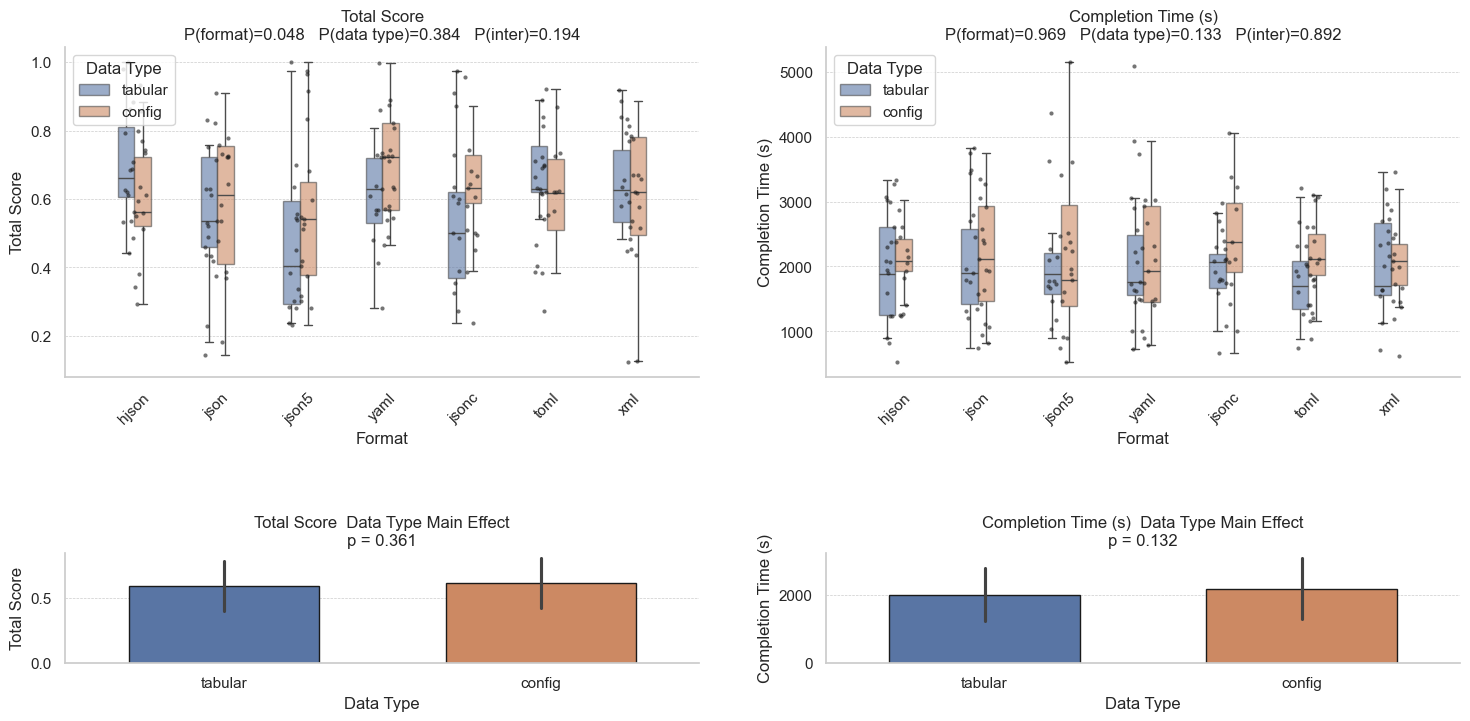

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import pandas as pd

# —— 1) 预计算各项检验 —— #

formats = sorted(df_merged['format'].unique())
metrics = ['total_score','duration_sec_total']
titles  = {'total_score':"Total Score", 'duration_sec_total':"Completion Time (s)"}
palette = {'tabular':'C0','config':'C1'}

# ANOVA p‐values
anova_p = {}
for met in metrics:
    m = ols(f"{met} ~ C(format)*C(task)", data=df_merged).fit()
    a = sm.stats.anova_lm(m, typ=2)
    anova_p[met] = {
        'format': a.loc['C(format)','PR(>F)'],
        'dtype':  a.loc['C(task)','PR(>F)'],
        'inter':  a.loc['C(format):C(task)','PR(>F)']
    }

# 格式的 Tukey HSD
tukey_res = {}
for met in metrics:
    tk   = pairwise_tukeyhsd(df_merged[met], df_merged['format'], alpha=0.05)
    df_tk= pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
    tukey_res[met] = df_tk[df_tk['p-adj']<0.05][['group1','group2','p-adj']]

# 简单效应：格式内的数据类型对比
simple_dtype = {}
for met in metrics:
    pvals = []
    for f in formats:
        g0 = df_merged[(df_merged.format==f)&(df_merged.task=='tabular')][met]
        g1 = df_merged[(df_merged.format==f)&(df_merged.task=='config')][met]
        _, p = ttest_ind(g0, g1, equal_var=False)
        pvals.append(p)
    rej, p_fdr, *_ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    simple_dtype[met] = {formats[i]:p_fdr[i] for i,r in enumerate(rej) if r}

# 数据类型主效应
dtype_p = {}
for met in metrics:
    t0 = df_merged[df_merged.task=='tabular'][met]
    t1 = df_merged[df_merged.task=='config'][met]
    _, p = ttest_ind(t0, t1, equal_var=False)
    dtype_p[met] = p

# —— 2) 绘图：更宽的画布 + 加大间距 —— #

sns.set(style="whitegrid", context="notebook")
fig = plt.figure(figsize=(18,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2, height_ratios=[3,1], hspace=0.8, wspace=0.2)

axes = {
    'box_TS': fig.add_subplot(gs[0,0]),
    'box_CT': fig.add_subplot(gs[0,1]),
    'bar_TS': fig.add_subplot(gs[1,0]),
    'bar_CT': fig.add_subplot(gs[1,1]),
}

# 上排：Format × Data Type 箱线 + 抖动
for met, key in zip(metrics, ['box_TS','box_CT']):
    ax = axes[key]
    sns.boxplot(x='format', y=met, hue='task', data=df_merged,
                palette=palette, width=0.4, fliersize=0,
                boxprops={'alpha':0.6}, ax=ax)
    sns.stripplot(x='format', y=met, data=df_merged,
                  color='k', dodge=True, jitter=0.15,
                  size=3, alpha=0.6, ax=ax)
    # 增加左右留白
    ax.margins(x=0.1)

    # Legend → Data Type
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["tabular","config"], title="Data Type", loc='upper left')

    # 标题
    p = anova_p[met]
    ax.set_title(
        f"{titles[met]}\n"
        f"P(format)={p['format']:.3f}   "
        f"P(data type)={p['dtype']:.3f}   "
        f"P(inter)={p['inter']:.3f}"
    )
    ax.set_xlabel("Format"); ax.set_ylabel(titles[met])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)

    # 显著格式对
    y0, y1 = df_merged[met].min(), df_merged[met].max()
    pad = 0.05*(y1-y0)
    for i,row in tukey_res[met].iterrows():
        a,b,pv = row
        x1,x2 = formats.index(a), formats.index(b)
        y = y1 + pad*(2 + i*1.5)
        ax.plot([x1,x1,x2,x2],[y,y+pad,y+pad,y],'k-')
        ax.text((x1+x2)/2, y+pad*0.2, f"p={pv:.3f}", ha='center')
    # 简单效应
    for j,f in enumerate(formats):
        if f in simple_dtype[met]:
            pv = simple_dtype[met][f]
            x0,x1 = j-0.2, j+0.2
            y2 = df_merged[df_merged.format==f][met].max() + pad*1.2
            ax.plot([x0,x0,x1,x1],[y2,y2+pad*0.6,y2+pad*0.6,y2],'k-')
            ax.text(j, y2+pad*0.8, f"p={pv:.3f}", ha='center')

# 下排：Data Type 主效应柱状图
for met, key in zip(metrics, ['bar_TS','bar_CT']):
    ax = axes[key]
    sns.barplot(x='task', y=met, data=df_merged,
                palette=palette, ci='sd', edgecolor='k', width=0.6, ax=ax)
    ax.set_xlabel("Data Type"); ax.set_ylabel(titles[met])
    p_dt = dtype_p[met]
    ax.set_title(f"{titles[met]}  Data Type Main Effect\np = {p_dt:.3f}")
    # 仅显著时加星号
    if p_dt < 0.05:
        y_max = df_merged[met].max()
        pad   = 0.05*(y_max - df_merged[met].min())
        ax.text(0.5, y_max+pad, "*", ha='center', va='bottom', fontsize=16)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

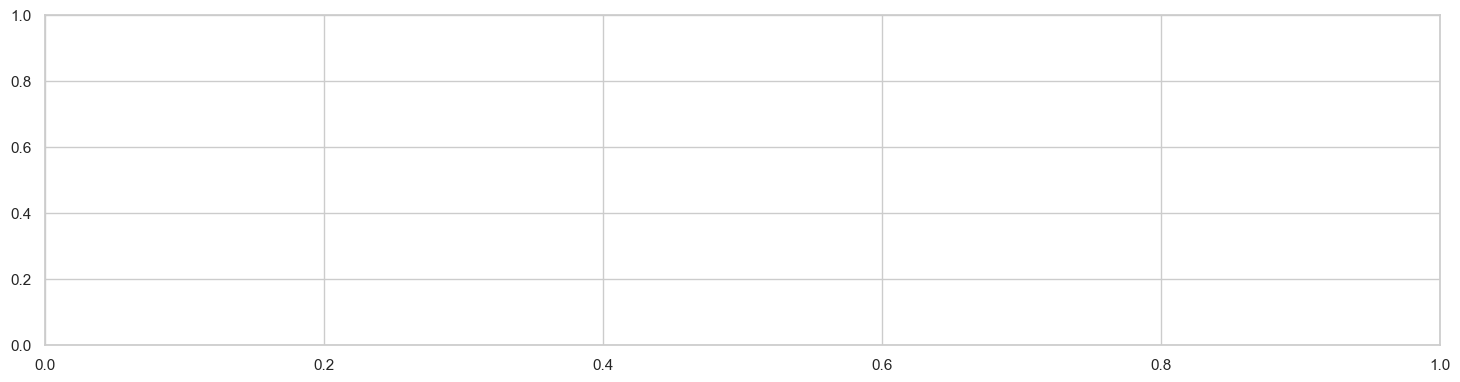

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import pandas as pd

# —— 1) 预计算各项检验 —— #

formats = sorted(df_merged['format'].unique())
metrics = ['total_score','duration_sec_total']
# 把 Total Score 改成 Overall Correctness
titles  = {
    'total_score':     "Overall Correctness",
    'duration_sec_total': "Completion Time (s)"
}
palette = {'tabular':'C0','config':'C1'}

# Two‑way ANOVA p‑values
anova_p = {}
for met in metrics:
    m = ols(f"{met} ~ C(format)*C(task)", data=df_merged).fit()
    a = sm.stats.anova_lm(m, typ=2)
    anova_p[met] = {
        'format': a.loc['C(format)','PR(>F)'],
        'dtype':  a.loc['C(task)','PR(>F)'],
        'inter':  a.loc['C(format):C(task)','PR(>F)']
    }

# 格式的全局 Tukey HSD
tukey_res = {}
for met in metrics:
    tk    = pairwise_tukeyhsd(df_merged[met], df_merged['format'], alpha=0.05)
    df_tk = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
    # 仅保留显著对
    tukey_res[met] = df_tk[df_tk['p-adj']<0.05][['group1','group2','p-adj']]

# 简单效应：每个格式内的 Data Type (tabular vs config) t‑test + FDR
simple_dtype = {}
for met in metrics:
    pvals = []
    for f in formats:
        g0 = df_merged[(df_merged.format==f) & (df_merged.task=='tabular')][met]
        g1 = df_merged[(df_merged.format==f) & (df_merged.task=='config')][met]
        _, p = ttest_ind(g0, g1, equal_var=False)
        pvals.append(p)
    rej, p_fdr, *_ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    simple_dtype[met] = {formats[i]:p_fdr[i] for i,r in enumerate(rej) if r}

# Data Type 主效应 t‑test
dtype_p = {}
for met in metrics:
    t0 = df_merged[df_merged.task=='tabular'][met]
    t1 = df_merged[df_merged.task=='config'][met]
    _, p = ttest_ind(t0, t1, equal_var=False)
    dtype_p[met] = p

# —— 2) 绘图：宽画布 + 行列间距 —— #

sns.set(style="whitegrid", context="notebook")
fig = plt.figure(figsize=(18,8))

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2,
                       height_ratios=[3,1],
                       hspace=0.8,   # 上下间距
                       wspace=0.2)   # 左右间距

axes = {
    'box_OC': fig.add_subplot(gs[0,0]),  # Overall Correctness
    'box_CT': fig.add_subplot(gs[0,1]),  # Completion Time
    'bar_OC': fig.add_subplot(gs[1,0]),
    'bar_CT': fig.add_subplot(gs[1,1]),
}

# 上排：Format × Data Type 箱线 + 抖动
for met, key in zip(metrics, ['box_OC','box_CT']):
    ax = axes[key]
    # 箱线
    sns.boxplot(
        x='format', y=met, hue='task', data=df_merged,
        palette=palette, width=0.4, fliersize=0,
        boxprops={'alpha':0.6}, ax=ax
    )
    # 黑色小点
    sns.stripplot(
        x='format', y=met, data=df_merged,
        color='k', dodge=True, jitter=0.15,
        size=3, alpha=0.6, ax=ax
    )
    # 左右留白
    ax.margins(x=0.1)

    # Legend -> Data Type
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["tabular","config"],
              title="Data Type", loc='upper left')

    # 标题
    p = anova_p[met]
    ax.set_title(
        f"{titles[met]}\n"
        f"P(format)={p['format']:.3f}   "
        f"P(data type)={p['dtype']:.3f}   "
        f"P(inter)={p['inter']:.3f}"
    )
    ax.set_xlabel("Format")
    ax.set_ylabel(titles[met])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)

    # 显著的全局格式对
    y0, y1 = df_merged[met].min(), df_merged[met].max()
    pad = 0.05 * (y1 - y0)
    for i, row in tukey_res[met].iterrows():
        a, b, pv = row
        x1, x2 = formats.index(a), formats.index(b)
        y = y1 + pad * (2 + i*1.5)
        ax.plot([x1, x1, x2, x2],
                [y, y+pad, y+pad, y], 'k-')
        ax.text((x1+x2)/2, y+pad*0.2, f"p={pv:.3f}", ha='center')

    # 显著的简单效应 (Data Type 内差异)
    for j, f in enumerate(formats):
        if f in simple_dtype[met]:
            pv = simple_dtype[met][f]
            x0, x1 = j-0.2, j+0.2
            y2 = df_merged[df_merged.format==f][met].max() + pad*1.2
            ax.plot([x0, x0, x1, x1],
                    [y2, y2+pad*0.6, y2+pad*0.6, y2], 'k-')
            ax.text(j, y2+pad*0.8, f"p={pv:.3f}", ha='center')

# 下排：Data Type 主效应柱状图
for met, key in zip(metrics, ['bar_OC','bar_CT']):
    ax = axes[key]
    sns.barplot(
        x='task', y=met, data=df_merged,
        palette=palette, ci='sd', edgecolor='k',
        width=0.6, ax=ax
    )
    ax.set_xlabel("Data Type")
    ax.set_ylabel(titles[met])
    p_dt = dtype_p[met]
    ax.set_title(f"{titles[met]}  Data Type Main Effect\np = {p_dt:.3f}")
    # 仅显著时加星号
    if p_dt < 0.05:
        y_max = df_merged[met].max()
        pad   = 0.05 * (y_max - df_merged[met].min())
        ax.text(0.5, y_max + pad, "*",
                ha='center', va='bottom', fontsize=16)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)

# —— 3) Format 主效应可视化（追加） —— #

# 新建画布
fig_f, axes_f = plt.subplots(1, 2, figsize=(18,5),
                             sharey=False,
                             gridspec_kw={'wspace':0.3})
sns.set(style="whitegrid", context="notebook")

for ax, met in zip(axes_f, metrics):
    # a) 单因素 ANOVA: format only
    mdl   = ols(f"{met} ~ C(format)", data=df_merged).fit()
    aov   = sm.stats.anova_lm(mdl, typ=2)
    p_fmt = aov.loc['C(format)', 'PR(>F)']
    
    # b) 箱线图 + 抖动点
    sns.boxplot(x='format', y=met, data=df_merged,
                palette='pastel', width=0.6, fliersize=0,
                boxprops={'alpha':0.6}, ax=ax)
    sns.stripplot(x='format', y=met, data=df_merged,
                  color='k', size=4, jitter=0.2, alpha=0.7,
                  ax=ax)
    ax.margins(x=0.05)
    
    # c) 标题 & 轴
    ax.set_title(
        f"{titles[met]}\nFormat Main Effect (ANOVA p={p_fmt:.3f})",
        fontweight='bold'
    )
    ax.set_xlabel("Format")
    ax.set_ylabel(titles[met])
    ax.tick_params(axis='x', rotation=45)
    
    # d) Tukey HSD 显著对的连线 + p‐值
    y0, y1 = df_merged[met].min(), df_merged[met].max()
    h      = 0.05 * (y1 - y0)
    for i, (g1, g2, pval) in enumerate(tukey_res[met].values):
        x1, x2 = formats.index(g1), formats.index(g2)
        y = y1 + h * (i + 1.5)
        ax.plot([x1, x1, x2, x2],
                [y, y + h, y + h, y],
                'k-')
        ax.text((x1 + x2) / 2, y + 0.5 * h,
                f"p={pval:.3f}", ha='center', va='bottom')
    
    # e) 美化
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()



/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_55413/4032846988.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


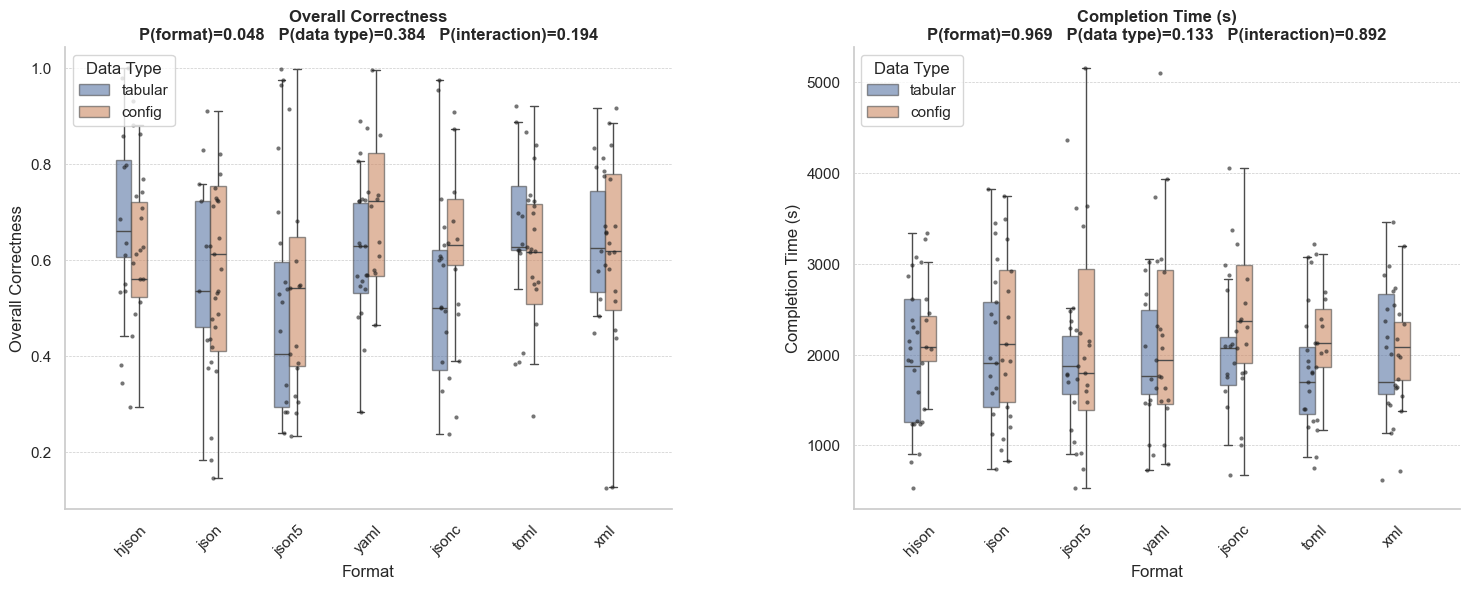

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# —— 1) 预计算二因素 ANOVA & Tukey HSD —— #

formats = sorted(df_merged['format'].unique())
metrics = ['total_score','duration_sec_total']
titles  = {
    'total_score':        "Overall Correctness",
    'duration_sec_total': "Completion Time (s)"
}
palette = {'tabular':'C0','config':'C1'}

# Two‑way ANOVA p‑values
anova_p = {}
tukey_res = {}
for met in metrics:
    # 二因素 ANOVA
    model = ols(f"{met} ~ C(format)*C(task)", data=df_merged).fit()
    aov   = sm.stats.anova_lm(model, typ=2)
    anova_p[met] = {
        'format': aov.loc['C(format)','PR(>F)'],
        'dtype':  aov.loc['C(task)','PR(>F)'],
        'inter':  aov.loc['C(format):C(task)','PR(>F)']
    }
    # Tukey HSD 只比较 format
    tk     = pairwise_tukeyhsd(df_merged[met], df_merged['format'], alpha=0.05)
    df_tk  = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
    tukey_res[met] = df_tk[df_tk['p-adj']<0.05][['group1','group2','p-adj']]

# —— 2) 绘图：只保留二因素交互面板 —— #

sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 2, figsize=(18,6), sharey=False, gridspec_kw={'wspace':0.3})

for ax, met in zip(axes, metrics):
    # 箱线 + 抖动点
    sns.boxplot(
        x='format', y=met, hue='task', data=df_merged,
        palette=palette, width=0.4, fliersize=0,
        boxprops={'alpha':0.6}, ax=ax
    )
    sns.stripplot(
        x='format', y=met, data=df_merged,
        color='k', dodge=True, jitter=0.15,
        size=3, alpha=0.6, ax=ax
    )
    ax.margins(x=0.1)

    # 图例：Data Type
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["tabular","config"], title="Data Type", loc='upper left')

    # 标题：二因素 ANOVA p‑值
    p = anova_p[met]
    ax.set_title(
        f"{titles[met]}\n"
        f"P(format)={p['format']:.3f}   "
        f"P(data type)={p['dtype']:.3f}   "
        f"P(interaction)={p['inter']:.3f}",
        fontweight='bold'
    )

    ax.set_xlabel("Format")
    ax.set_ylabel(titles[met])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)

    # 标注 Tukey HSD 显著对
    y_min, y_max = df_merged[met].min(), df_merged[met].max()
    pad = 0.05 * (y_max - y_min)
    for i, (g1, g2, pval) in enumerate(tukey_res[met].values):
        x1, x2 = formats.index(g1), formats.index(g2)
        y = y_max + pad*(i+1.5)
        ax.plot([x1, x1, x2, x2],
                [y, y+pad, y+pad, y],
                'k-')
        ax.text(
            (x1+x2)/2, y+pad*0.2,
            f"p={pval:.3f}",
            ha='center', va='bottom'
        )

plt.tight_layout()
plt.show()


In [77]:
quiz_config=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/tutorial_summary_config.csv')
quiz_tabular=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/tutorial_summary_tabular.csv')
quiz_config

,participantId,format,task,correct,num_wrong_attempts,duration_sec,wrong_choice_count
0,5755c957eb80c4000741a9ce,json5,tutorial,2,3,231.959,3
1,5795af044a84da00014c5df1,json,tutorial,2,1,325.241,1
2,57ca4b09993b08000192297b,xml,tutorial,2,2,251.848,2
3,5b3ec4332a5fbf00014eae57,toml,tutorial,2,1,405.141,0
4,5c4f5967aac8be0001716a65,xml,tutorial,2,4,224.576,5
...,...,...,...,...,...,...,...
100,680ebf035ab59d342f31726e,hjson,tutorial,1,6,2097.387,0
101,681374d36d7bd7ccb6f914f5,json5,tutorial,2,4,325.092,5
102,68138e7f96395f4c5f3a0a87,json,tutorial,2,3,2299.344,7
103,6818ca1523ece90f671e3601,json,tutorial,1,9,740.912,9


In [87]:
quiz=pd.concat([quiz_config,quiz_tabular])
quiz

,participantId,format,task,correct,num_wrong_attempts,duration_sec,wrong_choice_count
0,5755c957eb80c4000741a9ce,json5,tutorial,2,3,231.959,3
1,5795af044a84da00014c5df1,json,tutorial,2,1,325.241,1
2,57ca4b09993b08000192297b,xml,tutorial,2,2,251.848,2
3,5b3ec4332a5fbf00014eae57,toml,tutorial,2,1,405.141,0
4,5c4f5967aac8be0001716a65,xml,tutorial,2,4,224.576,5
...,...,...,...,...,...,...,...
102,67f1a4f8dd44e7cd5adffa29,json5,tutorial,2,3,706.270,5
103,67f1c7bd6f1c4a3d8deae02f,toml,tutorial,2,0,588.912,0
104,67f3619e16d4ca195fbd1bd0,yaml,tutorial,2,3,340.818,1
105,67f5bb69760b211cdfe8021c,jsonc,tutorial,1,5,277.498,0


In [78]:
writing_parse_config=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/writing_parse_config.csv')
writing_parse_tabular=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/writing_parse_tabular.csv')
modifying_parse_config=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/modifying_parse_config.csv')
modifying_parse_tabular=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/modifying_parse_tabular.csv')
writing_parse_config

,participantId,format,task,strict_parse,loose_parse
0,5f7f239e9b204e05b6c36538,json5,writing-task-config,False,False
1,676d220cd6e7101ccba18ba5,jsonc,writing-task-config,False,False
2,680ebf035ab59d342f31726e,hjson,writing-task-config,True,False
3,678faf5b31008609fd85b185,json5,writing-task-config,False,False
4,65e85a421f2dee53c62fbf45,json5,writing-task-config,False,False
...,...,...,...,...,...
100,67406c1303bd39d206ff2b50,xml,writing-task-config,False,False
101,67f66486e35051403284eb5e,xml,writing-task-config,False,False
102,60f7c71d1cffec381351b0b3,xml,writing-task-config,False,True
103,5fb4fcd1fce53c30649dd704,xml,writing-task-config,False,False


In [80]:
modifying_parse_config

,participantId,format,task,strict_parse,loose_parse
0,5f7f239e9b204e05b6c36538,json5,modifying-task-config-1,False,False
1,676d220cd6e7101ccba18ba5,jsonc,modifying-task-config-1,True,True
2,680ebf035ab59d342f31726e,hjson,modifying-task-config-1,True,False
3,678faf5b31008609fd85b185,json5,modifying-task-config-1,True,True
4,65e85a421f2dee53c62fbf45,json5,modifying-task-config-1,True,True
...,...,...,...,...,...
415,67d0088c269b3e96d9ba6019,hjson,modifying-task-config-1,False,False
416,61287939bc5a971fc15333e4,json,modifying-task-config-1,False,False
417,61287939bc5a971fc15333e4,json,modifying-task-config-2,False,False
418,61287939bc5a971fc15333e4,json,modifying-task-config-3,False,False


In [81]:
w_c_p=writing_parse_config
w_c_p['task']='config'
m_c_p=modifying_parse_config
m_c_p['task']='config'


w_t_p=writing_parse_tabular
w_t_p['task']='tabular'
m_t_p=modifying_parse_tabular
m_t_p['task']='tabular'

In [83]:
c_p=pd.concat([w_c_p,m_c_p])
c_p

,participantId,format,task,strict_parse,loose_parse
0,5f7f239e9b204e05b6c36538,json5,config,False,False
1,676d220cd6e7101ccba18ba5,jsonc,config,False,False
2,680ebf035ab59d342f31726e,hjson,config,True,False
3,678faf5b31008609fd85b185,json5,config,False,False
4,65e85a421f2dee53c62fbf45,json5,config,False,False
...,...,...,...,...,...
415,67d0088c269b3e96d9ba6019,hjson,config,False,False
416,61287939bc5a971fc15333e4,json,config,False,False
417,61287939bc5a971fc15333e4,json,config,False,False
418,61287939bc5a971fc15333e4,json,config,False,False


In [84]:
t_p=pd.concat([w_t_p,m_t_p])
t_p

,participantId,format,task,strict_parse,loose_parse
0,64457bc906c125cebd4bf66b,json5,tabular,False,False
1,6697c8b6d9d7baa7edd8c4d3,hjson,tabular,True,False
2,66475d6f7b27e4443ef0d031,json,tabular,False,False
3,67f5bb69760b211cdfe8021c,jsonc,tabular,False,False
4,67e571bef6af7ecd9c29ad72,json,tabular,True,True
...,...,...,...,...,...
423,6787d648d7b1963c661f9443,json5,tabular,False,False
424,6787d648d7b1963c661f9443,json5,tabular,False,False
425,66a662a0a709312db9de01f2,jsonc,tabular,False,False
426,66a662a0a709312db9de01f2,jsonc,tabular,False,False


In [93]:
tabular_parse_result=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/tabular_parse_result.csv') 
config_parse_result=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/config_parse_result.csv') 
config_parse_result

,participantId,format,task,strict_parse,loose_parse
0,659960f32faa4ff4b116de92,toml,writing-task-config,False,False
1,5f7f239e9b204e05b6c36538,json5,writing-task-config,False,False
2,676d220cd6e7101ccba18ba5,jsonc,writing-task-config,False,False
3,67b8636acd5ed420cc098b64,toml,writing-task-config,False,False
4,57ca4b09993b08000192297b,xml,writing-task-config,False,True
...,...,...,...,...,...
489,5c4f5967aac8be0001716a65,xml,modifying-task-config-4,True,True
490,6680071d60b3642bcf5dad37,jsonc,modifying-task-config-1,True,True
491,6680071d60b3642bcf5dad37,jsonc,modifying-task-config-2,False,False
492,6680071d60b3642bcf5dad37,jsonc,modifying-task-config-3,True,True


In [94]:
config_parse_result['task']='config'
tabular_parse_result['task']='tabular'
df_all = pd.concat([tabular_parse_result, config_parse_result], ignore_index=True)
df_all

,participantId,format,task,strict_parse,loose_parse
0,64457bc906c125cebd4bf66b,json5,tabular,False,False
1,6697c8b6d9d7baa7edd8c4d3,hjson,tabular,True,False
2,67e25388d573ec2d5f1c8442,yaml,tabular,False,False
3,67e5cf90b79d0874e1cf16b0,toml,tabular,True,True
4,67d00f24466a67ba7e41228e,toml,tabular,False,False
...,...,...,...,...,...
986,5c4f5967aac8be0001716a65,xml,config,True,True
987,6680071d60b3642bcf5dad37,jsonc,config,True,True
988,6680071d60b3642bcf5dad37,jsonc,config,False,False
989,6680071d60b3642bcf5dad37,jsonc,config,True,True


ValueError: must have at least one row in constraint matrix

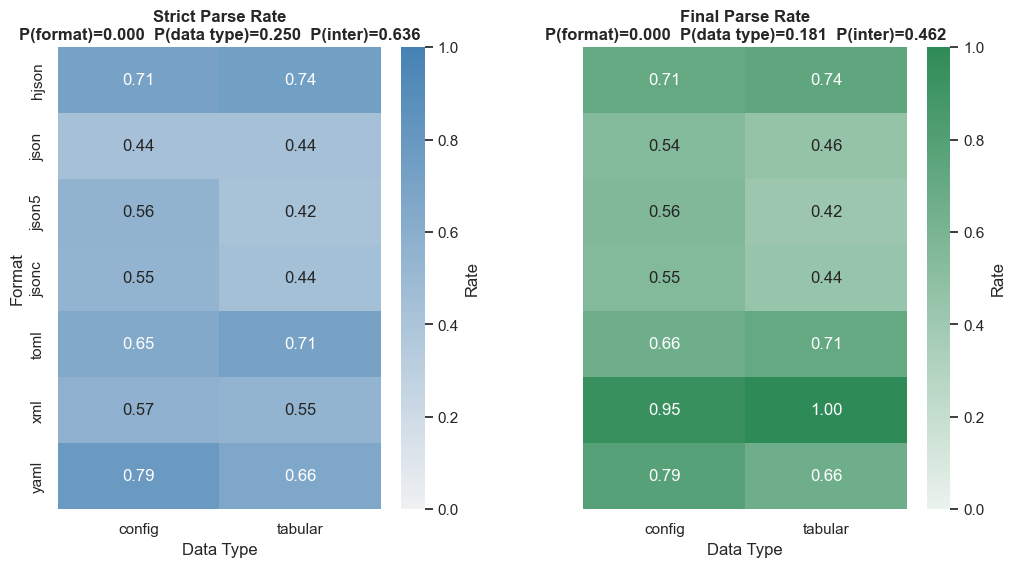

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm

# ── 0) 合并 & 计算 final_parse ── #
# df_all = pd.concat([w_t_p, m_t_p], ignore_index=True)
df_all = pd.concat([tabular_parse_result, config_parse_result], ignore_index=True)
df_all['strict_parse'] = df_all['strict_parse'].astype(int)
df_all['loose_parse']  = df_all['loose_parse'].astype(int)
df_all['final_parse']  = ((df_all['strict_parse'] + df_all['loose_parse']) > 0).astype(int)

# ── 1) 按 participant×format×task 聚合出“解析率” ── #
df_grp = (
    df_all
    .groupby(['participantId','format','task'])[['strict_parse','final_parse']]
    .mean()
    .reset_index()
)

# ── 2) 再按 format×task 聚合（为热力图消除重复索引） ── #
df_heat = (
    df_grp
    .groupby(['format','task'])[['strict_parse','final_parse']]
    .mean()
    .reset_index()
)

# ── 3) 二因素 ANOVA 计算 p 值 ── #
anova_p = {}
metrics = ['strict_parse','final_parse']
for met in metrics:
    model = ols(f"{met} ~ C(format)*C(task)", data=df_grp).fit()
    try:
        aov = sm.stats.anova_lm(model, typ=2)
    except ValueError:
        aov = sm.stats.anova_lm(model, typ=1)
    p_fmt  = aov.loc['C(format)',          'PR(>F)']
    p_task = aov.loc['C(task)',            'PR(>F)']
    p_int  = aov.loc['C(format):C(task)',  'PR(>F)'] if 'C(format):C(task)' in aov.index else float('nan')
    anova_p[met] = (p_fmt, p_task, p_int)

# ── 4) 构造 pivot tables ── #
pivot_strict = df_heat.pivot(index='format', columns='task', values='strict_parse')
pivot_final  = df_heat.pivot(index='format', columns='task', values='final_parse')

# ── 5) 绘制热力图 ── #
sns.set(style="white")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True, gridspec_kw={'wspace':0.3})

# Strict Parse Rate
p_fmt, p_task, p_int = anova_p['strict_parse']
sns.heatmap(
    pivot_strict, annot=True, fmt=".2f",
    vmin=0, vmax=1,
    cmap=sns.light_palette("steelblue", as_cmap=True),
    cbar_kws={"label": "Rate"},
    ax=ax1
)
ax1.set_title(
    f"Strict Parse Rate\n"
    f"P(format)={p_fmt:.3f}  "
    f"P(data type)={p_task:.3f}  "
    f"P(inter)={p_int:.3f}",
    fontweight='bold'
)
ax1.set_xlabel("Data Type")
ax1.set_ylabel("Format")

# Any Parse Rate
p_fmt, p_task, p_int = anova_p['final_parse']
sns.heatmap(
    pivot_final, annot=True, fmt=".2f",
    vmin=0, vmax=1,
    cmap=sns.light_palette("seagreen", as_cmap=True),
    cbar_kws={"label": "Rate"},
    ax=ax2
)
ax2.set_title(
    f"Final Parse Rate\n"
    f"P(format)={p_fmt:.3f}  "
    f"P(data type)={p_task:.3f}  "
    f"P(inter)={p_int:.3f}",
    fontweight='bold'
)
ax2.set_xlabel("Data Type")
ax2.set_ylabel("")



plt.tight_layout()
plt.show()


/var/folders/z4/3vn4jgtj71n_hdpgm6b1r_ww0000gp/T/ipykernel_55413/4083522951.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


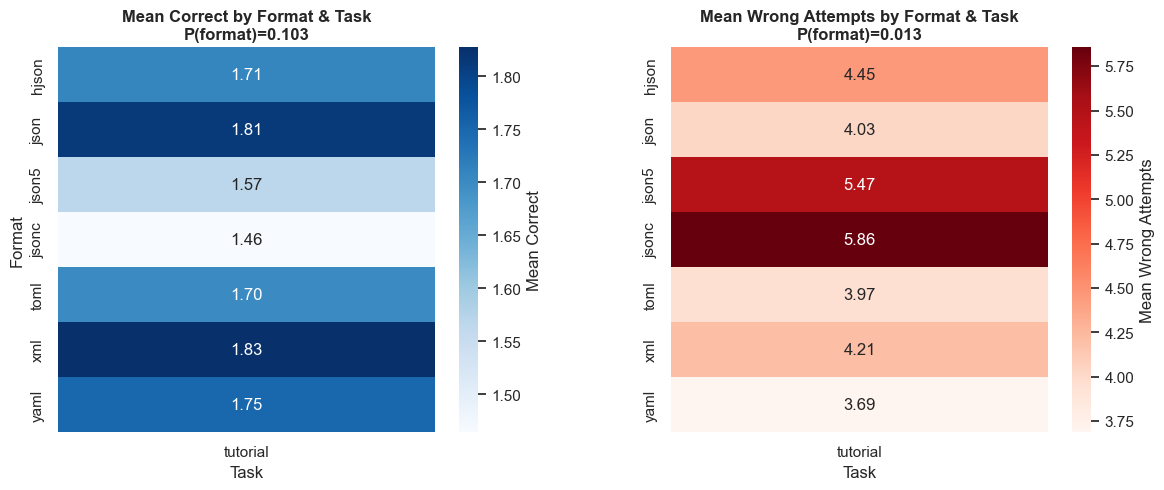

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# — 0) 假设 quiz 已经是合并好的 DataFrame — #
df = quiz.copy()

# — 1) 单因素 ANOVA for format + Tukey HSD — #
metrics = ['correct', 'num_wrong_attempts']
anova_p    = {}
tukey_res  = {}

for met in metrics:
    # One‑way ANOVA: only format
    model = ols(f"{met} ~ C(format)", data=df).fit()
    aov   = sm.stats.anova_lm(model, typ=2)
    anova_p[met] = aov.loc['C(format)', 'PR(>F)']
    
    # Tukey HSD for all pairwise format comparisons
    tk      = pairwise_tukeyhsd(df[met], df['format'], alpha=0.05)
    df_tk   = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
    # keep only p‑adj < 0.05 after correction
    tukey_res[met] = df_tk[df_tk['p-adj'] < 0.05][['group1','group2','p-adj']]

# — 2) 构造热力图数据 — #
pivot_correct = df.groupby(['format','task'])['correct'].mean().unstack()
pivot_wrong   = df.groupby(['format','task'])['num_wrong_attempts'].mean().unstack()

# — 3) 绘制两张热力图 — #
sns.set(style="white")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), gridspec_kw={'wspace':0.3})

# a) Mean Correct
p_fmt = anova_p['correct']
sns.heatmap(
    pivot_correct,
    annot=True, fmt=".2f",
    cmap="Blues",
    cbar_kws={"label":"Mean Correct"},
    ax=ax1
)
ax1.set_title(
    f"Mean Correct by Format & Task\n"
    f"P(format)={p_fmt:.3f}",
    fontweight='bold'
)
ax1.set_xlabel("Task")
ax1.set_ylabel("Format")

# annotate any significant pairwise differences
# if not tukey_res['correct'].empty:
#     for i,(g1,g2,pv) in enumerate(tukey_res['correct'].values):
#         ax1.text(1.02, 1 - formats.index(g1)/len(formats) - 0.1*i,
#                   f"{g1}≠{g2} (p={pv:.3f})",
#                   transform=ax1.transAxes,
#                   va='top', fontsize=8, color='red')

# b) Mean Wrong Attempts
p_fmt = anova_p['num_wrong_attempts']
sns.heatmap(
    pivot_wrong,
    annot=True, fmt=".2f",
    cmap="Reds",
    cbar_kws={"label":"Mean Wrong Attempts"},
    ax=ax2
)
ax2.set_title(
    f"Mean Wrong Attempts by Format & Task\n"
    f"P(format)={p_fmt:.3f}",
    fontweight='bold'
)
ax2.set_xlabel("Task")
ax2.set_ylabel("")

# annotate any significant Tukey pairs
# if not tukey_res['num_wrong_attempts'].empty:
#     for i,(g1,g2,pv) in enumerate(tukey_res['num_wrong_attempts'].values):
#         ax2.text(1.02, 1 - formats.index(g1)/len(formats) - 0.1*i,
#                   f"{g1}≠{g2} (p={pv:.3f})",
#                   transform=ax2.transAxes,
#                   va='top', fontsize=8, color='red')

plt.tight_layout()
plt.show()


In [106]:
lk_config=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/lk_config.csv')
lk_tabular=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/lk_tabular.csv')
cd_config=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/cd_config.csv')
cd_tabular=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/cd_tabular.csv')

nasa_config=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/nasa_config.csv')
nasa_tabular=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/nasa_tabular.csv')


In [108]:
nasa_config['task']='config'
nasa_tabular['task']='tabular'
nasa=pd.concat([nasa_config,nasa_tabular])
nasa

,Unnamed: 0,participantId,format,duration_sec,mental_demand,physical_demand,temporal_demand,performance,frustration,effort,task
0,0,659960f32faa4ff4b116de92,toml,46.501,100,100,70,10,70,100,config
1,1,5f7f239e9b204e05b6c36538,json5,34.281,98,40,71,78,87,99,config
2,2,676d220cd6e7101ccba18ba5,jsonc,60.500,95,100,95,40,80,100,config
3,3,67b8636acd5ed420cc098b64,toml,44.827,99,27,73,83,99,96,config
4,4,57ca4b09993b08000192297b,xml,30.029,90,0,10,65,75,85,config
...,...,...,...,...,...,...,...,...,...,...,...
102,102,67ab650c320eccf6141d4010,jsonc,18.749,65,61,59,57,62,60,tabular
103,103,65fad673a546ab14baf2f8d3,json5,31.495,85,80,85,80,75,85,tabular
104,104,67f1c7bd6f1c4a3d8deae02f,toml,86.136,85,60,20,10,10,100,tabular
105,105,67adb27bd5f5776fcb16da62,hjson,49.236,85,75,85,60,55,80,tabular


In [121]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# ─── 0) 假设你的 DataFrame 已经叫 nasa ────────────────────────────────
# 列: ['participantId','format','task',
#      'mental_demand','physical_demand','temporal_demand',
#      'performance','effort','frustration','duration_sec_total']

metrics = [
    'mental_demand','physical_demand','temporal_demand',
    'performance','effort','frustration'
]

# 确保分类变量
nasa['format'] = nasa['format'].astype('category')
nasa['task']   = nasa['task'].astype('category')
nasa['participantId'] = nasa['participantId'].astype('category')

# ─── 1) 重塑成长表 ───────────────────────────────────────────────────────
df_long = nasa.melt(
    id_vars = ['participantId','format','task'],
    value_vars = metrics,
    var_name = 'metric',
    value_name = 'rating'
)

# ─── 2) 对每个 metric 做两因素 Between‑Subjects ANOVA 和 Format Tukey HSD ──
results = []

for met in metrics:
    sub = df_long[df_long.metric == met]
    
    # 2.1) 两因素 ANOVA: format × task
    model2 = ols('rating ~ C(format)*C(task)', data=sub).fit()
    aov2   = sm.stats.anova_lm(model2, typ=2)
    p_fmt  = aov2.loc['C(format)',           'PR(>F)']
    p_task = aov2.loc['C(task)',             'PR(>F)']
    p_int  = aov2.loc['C(format):C(task)',   'PR(>F)']
    
    # 2.2) 单因素 Tukey HSD (只比较 format)
    tk     = pairwise_tukeyhsd(sub['rating'], sub['format'], alpha=0.05)
    tk_df  = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
    # 2.3) FDR 校正
    reject, p_fdr, _, _ = multipletests(
        tk_df['p-adj'].astype(float),
        alpha=0.05, method='fdr_bh'
    )
    sig_pairs = "; ".join(
        f"{r1}–{r2}(p={p:.3f})"
        for (r1,r2,p), use in zip(
            tk_df[['group1','group2','p-adj']].values, reject
        ) if use
    ) or "—"
    
    # 2.4) 收集结果
    results.append({
        'Metric'                : met,
        'P(format)'             : p_fmt,
        'P(task)'               : p_task,
        'P(format×task)'        : p_int,
        'Format post‑hoc (FDR)' : sig_pairs
    })

# ─── 3) 汇总成表 ────────────────────────────────────────────────────────
df_res = pd.DataFrame(results)

# 四舍五入
for col in ['P(format)','P(task)','P(format×task)']:
    df_res[col] = df_res[col].map(lambda p: f"{p:.3f}")

# 展示
print(df_res.to_string(index=False))


NameError: name 'cd_global_result' is not defined

In [118]:
cd_config['task']='config'
cd_tabular['task']='tabular'
cd=pd.concat([cd_config,cd_tabular])
cd

,participantId,format,difficutly_total,task,confidence_total
0,5755c957eb80c4000741a9ce,json5,0.113889,config,0.959402
1,5795af044a84da00014c5df1,json,0.261111,config,0.839744
2,57ca4b09993b08000192297b,xml,0.186111,config,0.696581
3,5b3ec4332a5fbf00014eae57,toml,0.683333,config,0.387821
4,5c4f5967aac8be0001716a65,xml,0.194444,config,0.704060
...,...,...,...,...,...
102,67f1a4f8dd44e7cd5adffa29,json5,0.713492,tabular,0.945665
103,67f1c7bd6f1c4a3d8deae02f,toml,0.064700,tabular,1.000000
104,67f3619e16d4ca195fbd1bd0,yaml,0.254796,tabular,0.944444
105,67f5bb69760b211cdfe8021c,jsonc,0.504900,tabular,0.675214


In [127]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# ─── 0) 确认并重命名 cd_global_result 中的列 ────────────────────────────
# 如果实际列名是 difficulty_score 和 confidence_score，就重命名
cd = cd.rename(columns={
    'difficulty_score': 'difficutly_total',
    'confidence_score': 'confidence_total'
})

# 再次确认：
print(cd.columns.tolist())  # 应该能看到 'difficulty_total' 和 'confidence_total'

# ─── 1) 把它们合并到 NASA‑TLX 数据里 ─────────────────────────────────
# 假设原 NASA‑TLX 表叫 nasa
nasa = nasa.merge(
    cd[['participantId','format','task','difficutly_total','confidence_total']],
    on=['participantId','format','task'],
    how='left'
)

# ─── 2) 定义所有要分析的指标 ─────────────────────────────────────────────
metrics = [
    'mental_demand','physical_demand','temporal_demand',
    'performance','effort','frustration',
    'difficutly_total','confidence_total'
]

# ─── 3) 确保分类字段都是 category ────────────────────────────────────
for col in ['participantId','format','task']:
    nasa[col] = nasa[col].astype('category')

# ─── 4) 宽表转成长表 ─────────────────────────────────────────────────
df_long = nasa.melt(
    id_vars   = ['participantId','format','task'],
    value_vars=metrics,
    var_name  ='metric',
    value_name='rating'
)

# ─── 5) 按 metric 做双因素 ANOVA + 格式间 Tukey + FDR 校正 ───────────────
results = []
for met in metrics:
    sub = df_long[df_long.metric == met]

    # 5.1) 两因素 ANOVA
    m2    = ols('rating ~ C(format)*C(task)', data=sub).fit()
    aov2  = sm.stats.anova_lm(m2, typ=2)
    p_fmt = aov2.loc['C(format)',         'PR(>F)']
    p_task= aov2.loc['C(task)',           'PR(>F)']
    p_int = aov2.loc['C(format):C(task)', 'PR(>F)']

    # 5.2) 格式间 Tukey HSD
    tk    = pairwise_tukeyhsd(sub['rating'], sub['format'], alpha=0.05)
    tkdf  = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])

    # 5.3) FDR 校正
    rej, p_fdr, _, _ = multipletests(
        tkdf['p-adj'].astype(float),
        alpha=0.05, method='fdr_bh'
    )
    sig = []
    for (g1,g2,p0), keep, p1 in zip(
            tkdf[['group1','group2','p-adj']].values,
            rej, p_fdr):
        if keep:
            sig.append(f"{g1}–{g2}(p={p1:.3f})")
    post = "; ".join(sig) if sig else "—"

    # 5.4) 存入结果
    results.append({
        'Metric'                : met,
        'P(format)'             : p_fmt,
        'P(task)'               : p_task,
        'P(format×task)'        : p_int,
        'Format post‑hoc (FDR)' : post
    })

# ─── 6) 汇总并格式化输出 ───────────────────────────────────────────────
df_res = pd.DataFrame(results)
for c in ['P(format)','P(task)','P(format×task)']:
    df_res[c] = df_res[c].map(lambda p: f"{p:.3f}")

print(df_res.to_string(index=False))


['participantId', 'format', 'difficutly_total', 'task', 'confidence_total']
          Metric P(format) P(task) P(format×task) Format post‑hoc (FDR)
   mental_demand     0.776   0.896          0.021                     —
 physical_demand     0.377   0.854          0.286                     —
 temporal_demand     0.316   0.936          0.039                     —
     performance     0.309   0.933          0.184                     —
          effort     0.894   0.720          0.082                     —
     frustration     0.204   0.652          0.037                     —
difficutly_total     0.133   0.461          0.022                     —
confidence_total     0.355   0.220          0.488                     —


In [129]:
lk=pd.concat([lk_config,lk_tabular])
lk

,format,task_order,score,task
0,hjson,1,0.733333,config
1,hjson,2,0.800000,config
2,hjson,3,0.933333,config
3,hjson,4,0.666667,config
4,hjson,5,0.866667,config
...,...,...,...,...
65,yaml,6,0.385696,tabular
66,yaml,7,0.935737,tabular
67,yaml,8,0.747327,tabular
68,yaml,9,0.884449,tabular


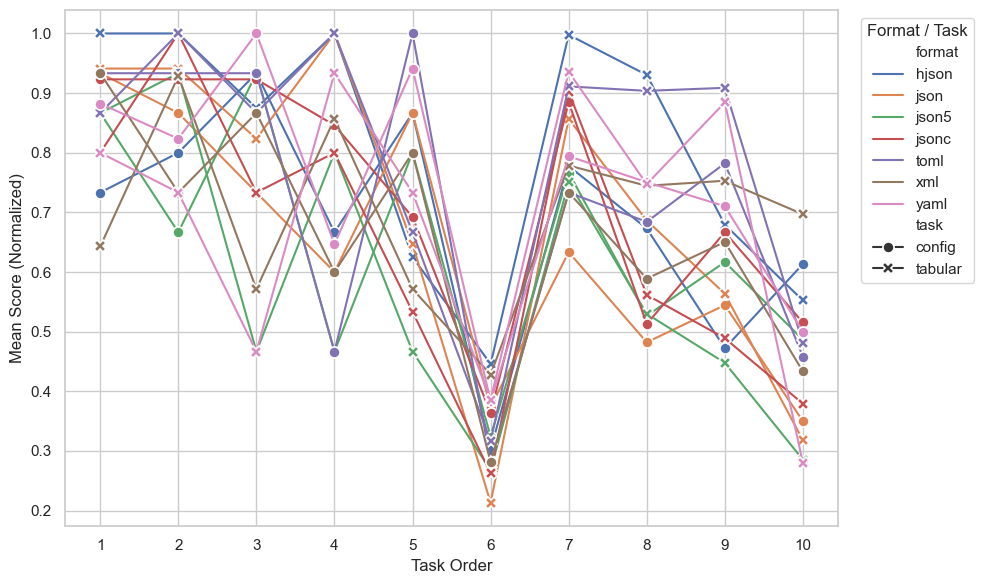

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# — assume lk is your DataFrame with columns ['format','task_order','score','task'] —

# 1) Make sure task_order is treated as an ordered category (so T1…T10 plot in order)
lk['task_order'] = lk['task_order'].astype(int)
lk = lk.sort_values('task_order')

# 2) Compute mean score per format × task_order × task
lk_mean = (
    lk
    .groupby(['format','task_order','task'], as_index=False)
    ['score']
    .mean()
)

# 3) Plot
sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(10,6))

# each format gets its own color; each task its own marker
sns.lineplot(
    data=lk_mean,
    x='task_order', y='score',
    hue='format',      # color by format
    style='task',      # marker by task
    markers=True, 
    dashes=False,      # solid lines
    linewidth=1.5,
    markeredgewidth=1.2,
    markersize=8,
)

# plt.title("Learning Curves: Normalized Score over Task Order")
plt.xlabel("Task Order")
plt.ylabel("Mean Score (Normalized)")
plt.xticks(range(1, lk['task_order'].max()+1))
plt.legend(title="Format / Task", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


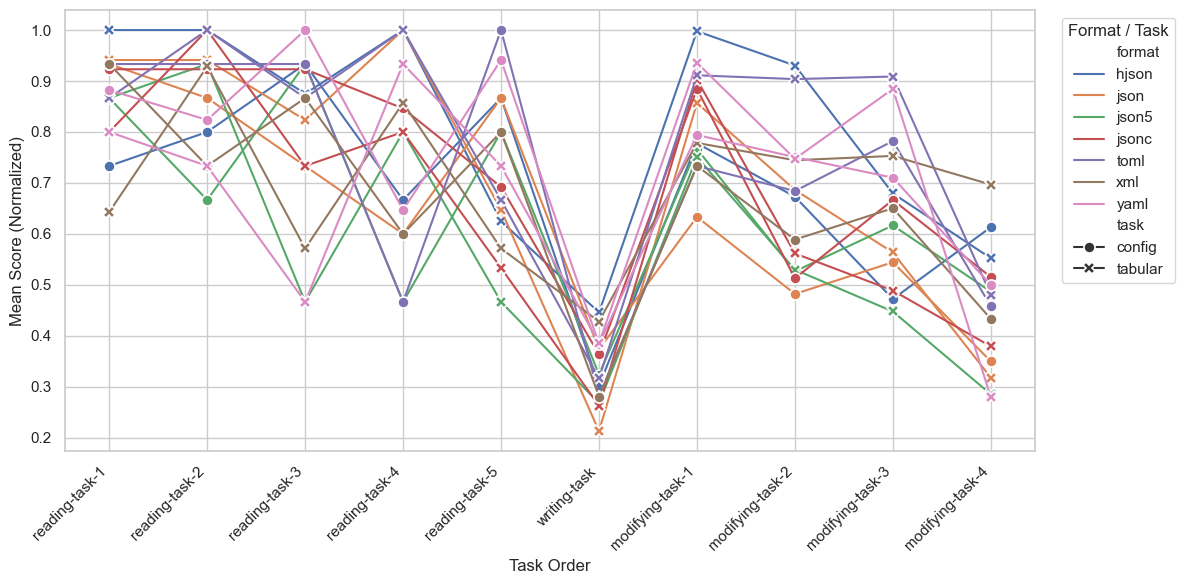

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# — assume lk is your DataFrame with columns ['format','task_order','score','task'] —

# 1) Make sure task_order is numeric and sorted
lk['task_order'] = lk['task_order'].astype(int)
lk = lk.sort_values('task_order')

# 2) Compute mean score per format × task_order × task
lk_mean = (
    lk
    .groupby(['format','task_order','task'], as_index=False)
    ['score']
    .mean()
)

# 3) Prepare custom tick labels
custom_labels = [
    "reading-task-1",
    "reading-task-2",
    "reading-task-3",
    "reading-task-4",
    "reading-task-5",
    "writing-task",
    "modifying-task-1",
    "modifying-task-2",
    "modifying-task-3",
    "modifying-task-4",
]

# 4) Plot
sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(12,6))

sns.lineplot(
    data=lk_mean,
    x='task_order', y='score',
    hue='format',      # color by format
    style='task',      # marker by task
    markers=True, 
    dashes=False,      # solid lines
    linewidth=1.5,
    markeredgewidth=1.2,
    markersize=8,
)

plt.xlabel("Task Order")
plt.ylabel("Mean Score (Normalized)")

# apply custom tick labels
plt.xticks(
    ticks=range(1, len(custom_labels) + 1),
    labels=custom_labels,
    rotation=45,       # 如果标签较长，可以斜着显示
    ha='right'         # 右对齐
)

plt.legend(title="Format / Task", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


In [135]:
event_config=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/total_config.csv')
event_tabular=pd.read_csv('/Users/shiyi.he/Desktop/DSF_Analysis/total_tabular.csv')
event_config['task']='config'
event_tabular['task']='tabular'
event=pd.concat([event_config,event_tabular])
event

,participantId,format,task,help_count,search_count,copy_count,paste_count,q10_years,q10_years_binned,total_score,interaction_total
0,5755c957eb80c4000741a9ce,json5,config,1,3,3,2,13.33,3+,1.000000,3
1,5795af044a84da00014c5df1,json,config,1,0,1,1,8.75,3+,0.584921,0
2,57ca4b09993b08000192297b,xml,config,2,1,1,9,10.00,3+,0.890351,1
3,5b3ec4332a5fbf00014eae57,toml,config,10,0,0,2,2.00,1–2,0.657341,0
4,5c4f5967aac8be0001716a65,xml,config,4,4,5,9,0.67,0–1,0.771825,4
...,...,...,...,...,...,...,...,...,...,...,...
102,67f1a4f8dd44e7cd5adffa29,json5,tabular,0,0,0,0,4.00,2-3,0.373609,0
103,67f1c7bd6f1c4a3d8deae02f,toml,tabular,0,0,19,9,4.00,2-3,0.691687,0
104,67f3619e16d4ca195fbd1bd0,yaml,tabular,0,0,0,0,5.00,2-3,0.572115,0
105,67f5bb69760b211cdfe8021c,jsonc,tabular,0,0,0,0,2.00,1–2,0.668555,0


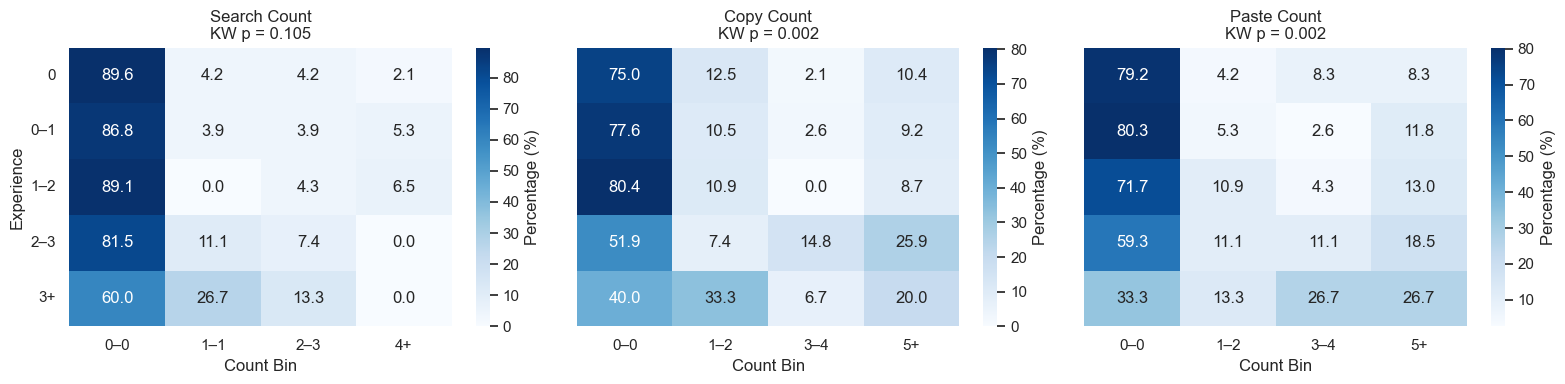

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# 假设你的 DataFrame 叫 event，包含：
# ['participantId','format','task','q10_years_binned',
#  'search_count','copy_count','paste_count', …]

# 1) 修正后的分箱函数
def bin_counts(series, bins):
    """
    把 series (非负整数) 分到「[bins[0], bins[1]-1], [bins[1], bins[2]-1], …, [bins[-1], +∞)」，
    并生成对应的字符串标签。
    """
    # 构造标签，长度等于 len(bins)
    labels = []
    for i in range(len(bins)):
        if i < len(bins) - 1:
            lower = bins[i]
            upper = bins[i+1] - 1
            labels.append(f"{lower}–{upper}")
        else:
            labels.append(f"{bins[i]}+")
    # bin_edges = bins + [∞]
    edges = bins + [np.inf]
    return pd.cut(
        series,
        bins=edges,
        labels=labels,
        right=False,      # 左闭右开
        include_lowest=True
    )

# 2) 定义每个事件的分箱边界
bin_specs = {
    'search_count': [0, 1, 2, 4],   # -> ["0–0","1–1","2–3","4+"]
    'copy_count':   [0, 1, 3, 5],   # -> ["0–0","1–2","3–4","5+"]
    'paste_count':  [0, 1, 3, 5],   # 同上
}

# 3) 在 event 中生成分箱列
for ev, bins in bin_specs.items():
    if ev not in event.columns:
        raise KeyError(f"找不到列 `{ev}`，请确认列名！")
    event[f"{ev}_bin"] = bin_counts(event[ev], bins)

# 4) 绘制三个子图
sns.set(style="white")
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, ev in zip(axes, bin_specs):
    bin_col = f"{ev}_bin"
    # 计算每个经验段下各区间的百分比
    ct = (
        event
        .groupby(['q10_years_binned', bin_col])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum() * 100)
        .unstack(fill_value=0)
    )
    # Kruskal–Wallis 检验（使用原始 count 列）
    groups = [grp[ev].values for _, grp in event.groupby('q10_years_binned')]
    kw_stat, kw_p = kruskal(*groups)

    sns.heatmap(
        ct,
        annot=True, fmt=".1f",
        cmap="Blues",
        cbar_kws={"label": "Percentage (%)"},
        ax=ax
    )
    ax.set_title(f"{ev.replace('_',' ').title()}\nKW p = {kw_p:.3f}")
    ax.set_xlabel("Count Bin")
    ax.set_ylabel("Experience" if ax is axes[0] else "")
    yticklabels = ['0', '0–1', '1–2', '2–3', '3+']
    ax.set_yticklabels(yticklabels, rotation=0)

plt.tight_layout()
plt.show()


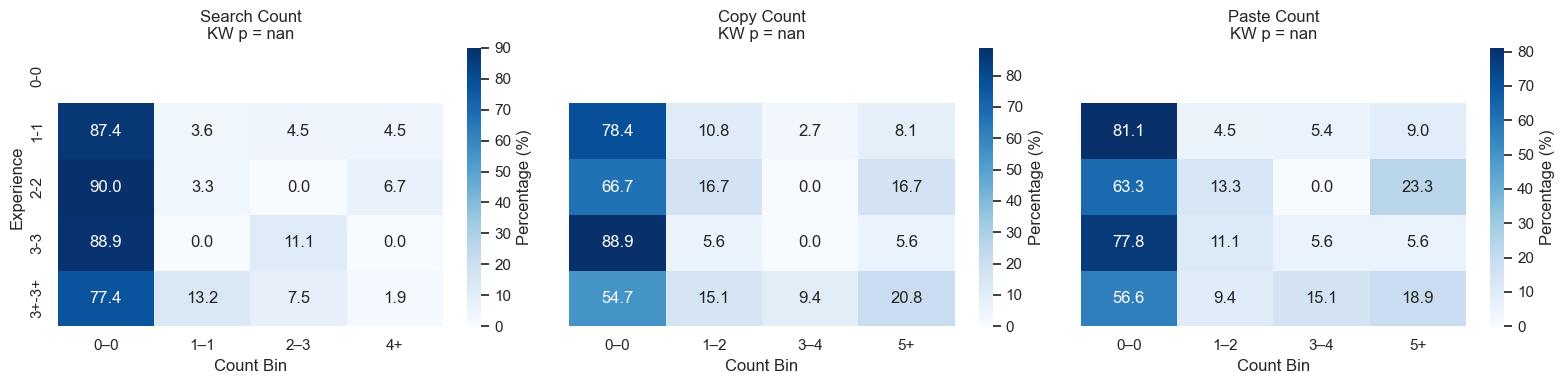

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# 假设你的 DataFrame 是 event，包含列：
# 'q10_years', 'search_count', 'copy_count', 'paste_count', ...

# 1) 分箱函数（用于 count 列）
def bin_counts(series, bins):
    labels = []
    for i in range(len(bins)):
        if i < len(bins) - 1:
            labels.append(f"{bins[i]}–{bins[i+1]-1}")
        else:
            labels.append(f"{bins[i]}+")
    edges = bins + [np.inf]
    return pd.cut(series, bins=edges, labels=labels, right=False, include_lowest=True)

# 2) 经验年数分箱（重新用 q10_years 列）
exp_bins = [0, 1, 2, 3]
exp_labels = ["0", "1", "2", "3", "3+"]
event["experience_bin"] = pd.cut(
    event["q10_years"],
    bins=[-np.inf] + exp_bins + [np.inf],
    labels=exp_labels,
    right=False,
    include_lowest=True
)

# 3) 定义每个事件的 count 分箱边界
bin_specs = {
    'search_count': [0, 1, 2, 4],
    'copy_count':   [0, 1, 3, 5],
    'paste_count':  [0, 1, 3, 5],
}

# 4) 应用 count 分箱
for ev, bins in bin_specs.items():
    if ev not in event.columns:
        raise KeyError(f"找不到列 `{ev}`，请确认列名！")
    event[f"{ev}_bin"] = bin_counts(event[ev], bins)

# 5) 绘图
sns.set(style="white")
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, ev in zip(axes, bin_specs):
    bin_col = f"{ev}_bin"
    # 分组计算百分比
    ct = (
        event
        .groupby(['experience_bin', bin_col])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum() * 100)
        .unstack(fill_value=0)
    )

    # Kruskal–Wallis 检验
    groups = [grp[ev].values for _, grp in event.groupby('experience_bin')]
    kw_stat, kw_p = kruskal(*groups)

    sns.heatmap(
        ct,
        annot=True, fmt=".1f",
        cmap="Blues",
        cbar_kws={"label": "Percentage (%)"},
        ax=ax
    )
    ax.set_title(f"{ev.replace('_',' ').title()}\nKW p = {kw_p:.3f}")
    ax.set_xlabel("Count Bin")
    ax.set_ylabel("Experience" if ax is axes[0] else "")

plt.tight_layout()
plt.show()


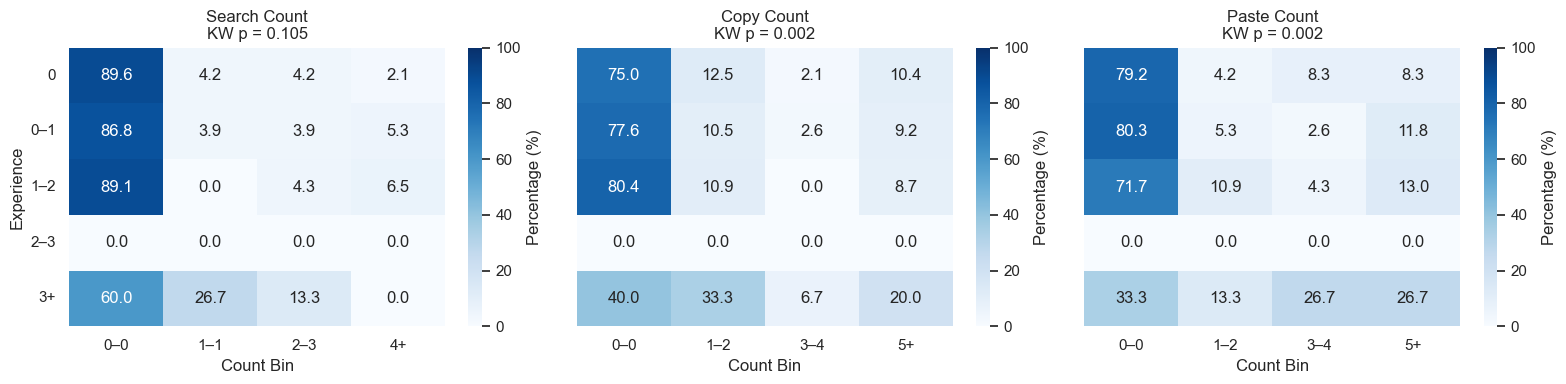

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# —— 假设你的 DataFrame 叫 event —— #
# 至少包含 ['participantId','q10_years_binned','search_count','copy_count','paste_count']

# —— 0) 统一把经验段做成字符串，并指定顺序 —— #
# 如果 q10_years_binned 是元组，取第一个；否则直接 str
event['experience'] = event['q10_years_binned'].apply(
    lambda x: x[0] if isinstance(x, (tuple, list)) else str(x)
)
experience_order = ["0", "0–1", "1–2", "2–3", "3+"]

# —— 1) 分箱函数 —— #
def bin_counts(series, bins):
    # 构造标签
    labels = []
    for i in range(len(bins)):
        if i < len(bins) - 1:
            labels.append(f"{bins[i]}–{bins[i+1]-1}")
        else:
            labels.append(f"{bins[i]}+")
    edges = bins + [np.inf]
    return pd.cut(series, bins=edges, labels=labels,
                  right=False, include_lowest=True)

bin_specs = {
    'search_count': [0, 1, 2, 4],   # -> ["0–0","1–1","2–3","4+"]
    'copy_count':   [0, 1, 3, 5],   # -> ["0–0","1–2","3–4","5+"]
    'paste_count':  [0, 1, 3, 5],   # 同上
}

# 生成每个事件的分箱列
for ev, bins in bin_specs.items():
    event[f"{ev}_bin"] = bin_counts(event[ev], bins)

# —— 2) 绘图 —— #
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, (ev, bins) in zip(axes, bin_specs.items()):
    bin_col = f"{ev}_bin"
    
    # 明确列标签顺序
    col_labels = [f"{bins[i]}–{bins[i+1]-1}" for i in range(len(bins)-1)] + [f"{bins[-1]}+"]
    
    # a) crosstab 计算百分比，并按行列都 reindex
    ct = (
        pd.crosstab(
            event['experience'],
            event[bin_col],
            normalize='index'
        ) * 100
    ).reindex(
        index=experience_order,
        columns=col_labels,
        fill_value=0
    )
    
    # b) Kruskal–Wallis 检验
    groups = [
        grp[ev].values
        for _, grp in event.groupby('experience')
        if len(grp) > 0
    ]
    if len(groups) >= 2:
        _, p_val = kruskal(*groups)
        subtitle = f"KW p = {p_val:.3f}"
    else:
        subtitle = "KW p = —"
    
    # c) 画热力图
    sns.heatmap(
        ct,
        annot=True, fmt=".1f",
        cmap="Blues", vmin=0, vmax=100,
        cbar_kws={"label":"Percentage (%)"},
        ax=ax
    )
    ax.set_title(f"{ev.replace('_',' ').title()}\n{subtitle}")
    ax.set_xlabel("Count Bin")
    if ax is axes[0]:
        ax.set_ylabel("Experience")
    else:
        ax.set_ylabel("")
    
    # 手动设置刻度标签
    ax.set_yticks(np.arange(len(experience_order)) + 0.5)
    ax.set_yticklabels(experience_order, rotation=0)
    ax.set_xticklabels(col_labels, rotation=0)

plt.tight_layout()
plt.show()


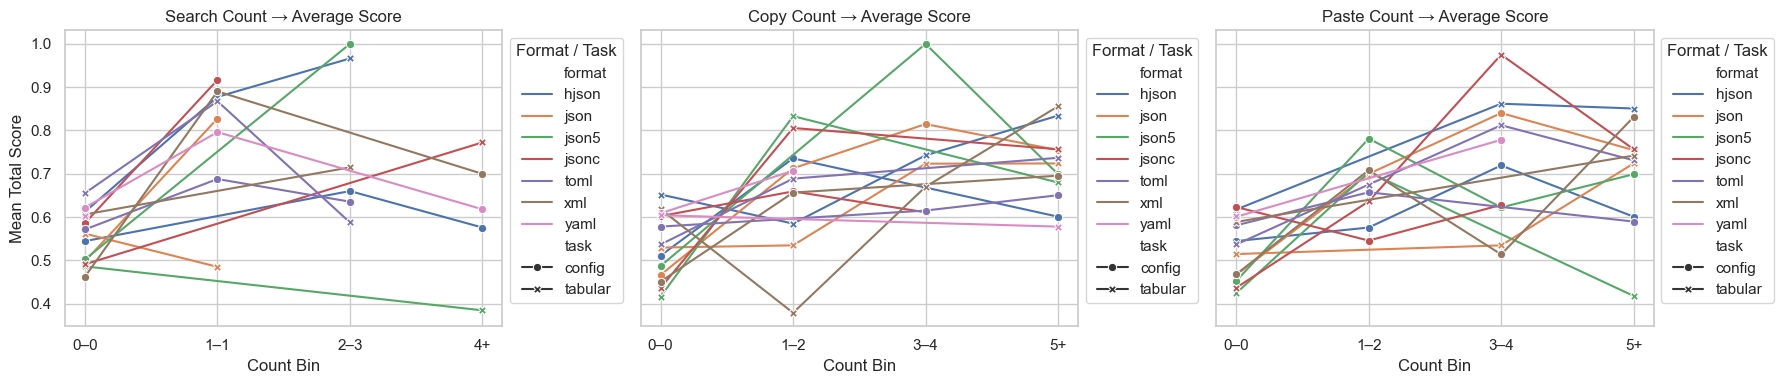

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# —— 假设 event 已经包含 strict_parse、final_parse 的分箱列，以及 total_score, format, task —— #

events = ['search_count', 'copy_count', 'paste_count']
bin_cols = [f"{ev}_bin" for ev in events]

# 计算平均得分
mean_scores = {}
for ev, col in zip(events, bin_cols):
    df = (
        event
        .groupby([col, 'format', 'task'], observed=True)['total_score']
        .mean()
        .reset_index()
    )
    mean_scores[ev] = df

# —— 画折线子图 —— #
sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for ax, ev, col in zip(axes, events, bin_cols):
    df = mean_scores[ev]
    # 确保顺序
    df[col] = pd.Categorical(df[col],
                             categories=event[col].cat.categories,
                             ordered=True)
    sns.lineplot(
        data=df,
        x=col, y='total_score',
        hue='format',    # 不同颜色 = 不同 format
        style='task',    # 不同线型/标记 = 数据类型
        markers=True,
        dashes=False,
        ax=ax
    )
    ax.set_title(f"{ev.replace('_',' ').title()} → Average Score")
    ax.set_xlabel("Count Bin")
    if ax is axes[0]:
        ax.set_ylabel("Mean Total Score")
    else:
        ax.set_ylabel("")
    ax.legend(title="Format / Task", bbox_to_anchor=(1,1), loc='upper left')

plt.tight_layout()
plt.show()


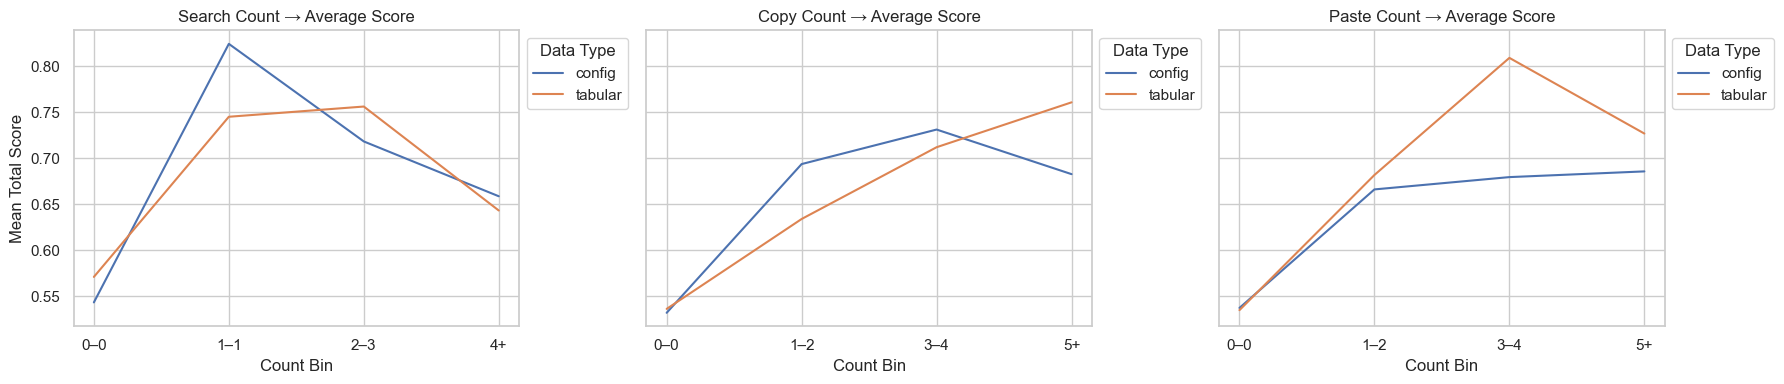

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# —— 假设 event 已经包含 strict_parse、final_parse 的分箱列，以及 total_score, format, task —— #

events = ['search_count', 'copy_count', 'paste_count']
bin_cols = [f"{ev}_bin" for ev in events]

# 计算平均得分（只区分 task，不区分 format）
mean_scores = {}
for ev, col in zip(events, bin_cols):
    df = (
        event
        .groupby([col, 'task'], observed=True)['total_score']
        .mean()
        .reset_index()
    )
    mean_scores[ev] = df

# —— 画折线子图 —— #
sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for ax, ev, col in zip(axes, events, bin_cols):
    df = mean_scores[ev]
    # 确保顺序
    df[col] = pd.Categorical(df[col],
                             categories=event[col].cat.categories,
                             ordered=True)
    sns.lineplot(
        data=df,
        x=col, y='total_score',
        hue='task',       # 只用数据类型区分颜色
        markers=True,
        dashes=False,
        ax=ax
    )
    ax.set_title(f"{ev.replace('_',' ').title()} → Average Score")
    ax.set_xlabel("Count Bin")
    if ax is axes[0]:
        ax.set_ylabel("Mean Total Score")
    else:
        ax.set_ylabel("")
    ax.legend(title="Data Type", bbox_to_anchor=(1,1), loc='upper left')

plt.tight_layout()
plt.show()


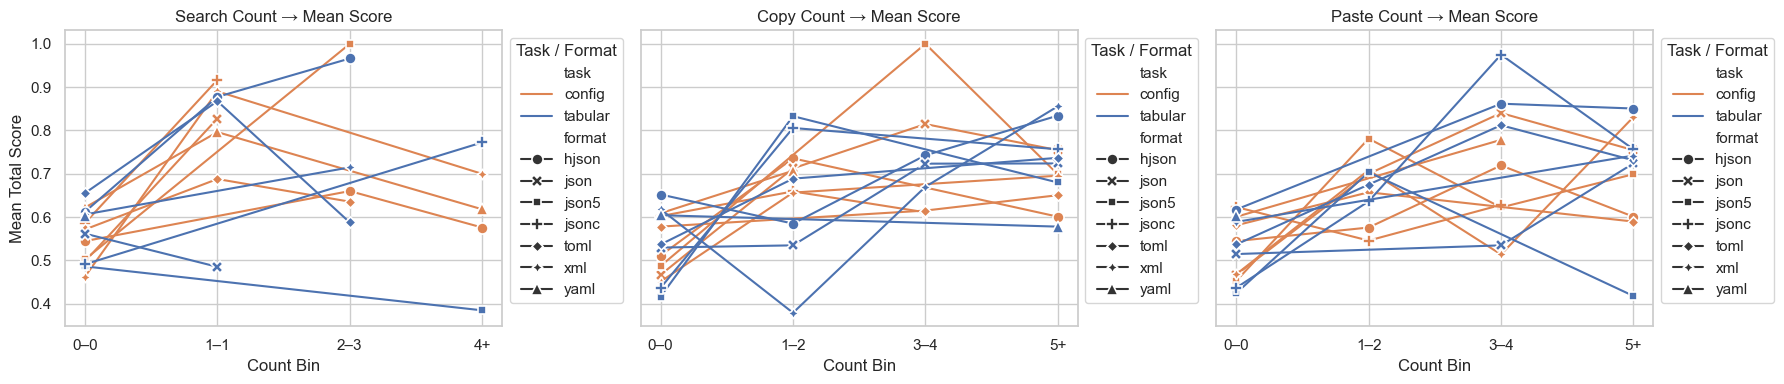

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# —— 假设 event 已包含以下列：
#    ['format','task','total_score',
#     'search_count_bin','copy_count_bin','paste_count_bin']
events = ['search_count', 'copy_count', 'paste_count']
bin_cols = [f"{ev}_bin" for ev in events]

# 先把格式做成有序分类，保证图中顺序一致
for col in bin_cols:
    event[col] = pd.Categorical(
        event[col],
        categories=event[col].cat.categories,
        ordered=True
    )

# 计算平均分
mean_scores = {}
for ev, col in zip(events, bin_cols):
    df = (
        event
        .groupby([col, 'format', 'task'], observed=True)['total_score']
        .mean()
        .reset_index()
    )
    mean_scores[ev] = df

# 画图
sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for ax, ev, col in zip(axes, events, bin_cols):
    df = mean_scores[ev]
    sns.lineplot(
        data=df,
        x=col, y='total_score',
        hue='task',       # 用颜色区分 Data Type
        style='format',   # 用不同 marker/line 区分 Format
        markers=True,
        dashes=False,
        ax=ax,
        palette={'tabular':'C0','config':'C1'},  # 保持任务颜色
        markeredgewidth=1.2, markersize=8
    )
    ax.set_title(f"{ev.replace('_',' ').title()} → Mean Score")
    ax.set_xlabel("Count Bin")
    if ax is axes[0]:
        ax.set_ylabel("Mean Total Score")
    else:
        ax.set_ylabel("")
    # 调整图例：任务在图例上层，格式在下层
    handles, labels = ax.get_legend_handles_labels()
    # legend handles 按 [task colors..., format markers...] 排序
    n_task = df['task'].nunique()
    ax.legend(
        handles=handles[:n_task] + handles[n_task:],
        labels=labels[:n_task] + labels[n_task:],
        title="Task / Format",
        bbox_to_anchor=(1, 1), loc='upper left'
    )

plt.tight_layout()
plt.show()


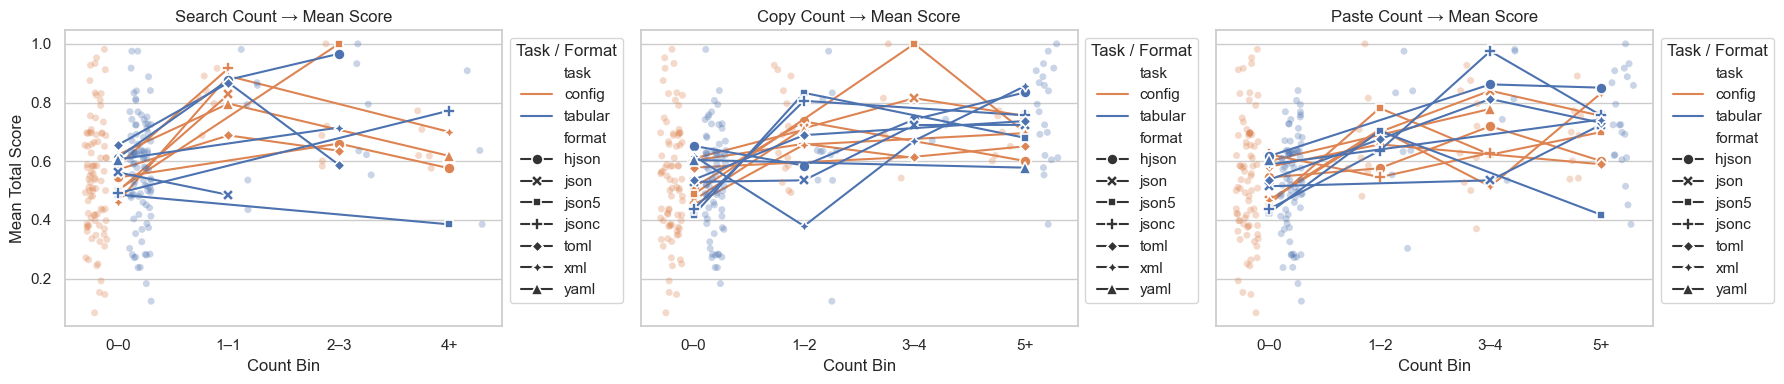

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假设你的 DataFrame 叫 event，已经包含了:
# ['format','task','total_score',
#  'search_count_bin','copy_count_bin','paste_count_bin']

events = ['search_count', 'copy_count', 'paste_count']
bin_cols = [f"{ev}_bin" for ev in events]

# 先把 bin 列都变成有序分类，
# 通过去掉末尾 '+' 后再转 int 来排序：
for col in bin_cols:
    uniq = list(event[col].unique())
    # 按区间最小值排序
    ordered = sorted(
        uniq,
        key=lambda x: int(x.split('–')[0].rstrip('+'))
    )
    event[col] = pd.Categorical(event[col], categories=ordered, ordered=True)

# 计算每个 bin × format × task 的平均分
mean_scores = {
    ev: (
        event
        .groupby([f"{ev}_bin", 'format', 'task'], observed=True)['total_score']
        .mean()
        .reset_index()
    )
    for ev in events
}

sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for ax, ev, col in zip(axes, events, bin_cols):
    # 1) 先画散点 (stripplot)
    sns.stripplot(
        data=event,
        x=col, y='total_score',
        hue='task',       # 颜色：Data Type
        dodge=True,
        jitter=0.2,
        alpha=0.3,
        size=5,
        palette={'tabular':'C0','config':'C1'},
        ax=ax,
        legend=False
    )

    # 2) 再画线 (lineplot) + 95% CI
    dfm = mean_scores[ev]
    sns.lineplot(
        data=dfm,
        x=col, y='total_score',
        hue='task',      # 颜色：Data Type
        style='format',  # 线型/marker：Format
        markers=True,
        dashes=False,
        ci=95,
        palette={'tabular':'C0','config':'C1'},
        markeredgewidth=1.2,
        markersize=8,
        ax=ax
    )

    ax.set_title(f"{ev.replace('_',' ').title()} → Mean Score")
    ax.set_xlabel("Count Bin")
    if ax is axes[0]:
        ax.set_ylabel("Mean Total Score")
    else:
        ax.set_ylabel("")

    # 细调图例：先列出 task，再列出 format
    handles, labels = ax.get_legend_handles_labels()
    n_task = event['task'].nunique()
    ax.legend(
        handles=handles[:n_task] + handles[n_task:],
        labels=labels[:n_task] + labels[n_task:],
        title="Task / Format",
        bbox_to_anchor=(1, 1),
        loc='upper left'
    )

plt.tight_layout()
plt.show()


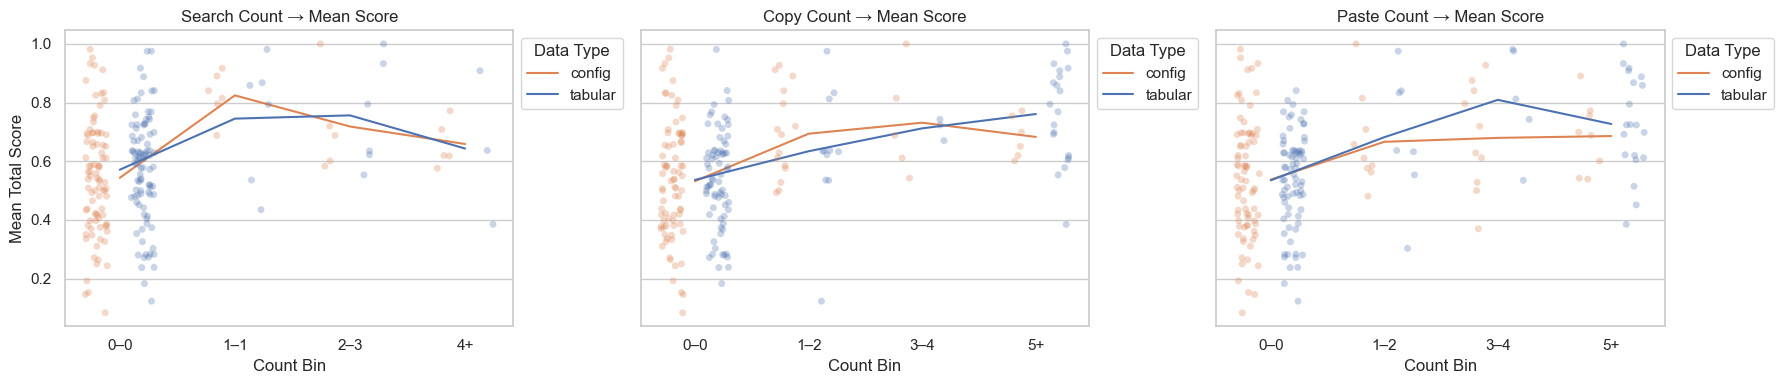

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

events = ['search_count', 'copy_count', 'paste_count']
bin_cols = [f"{ev}_bin" for ev in events]

# 设置 bin 列为有序分类（用于排序）
for col in bin_cols:
    uniq = list(event[col].unique())
    ordered = sorted(
        uniq,
        key=lambda x: int(x.split('–')[0].rstrip('+'))
    )
    event[col] = pd.Categorical(event[col], categories=ordered, ordered=True)

# 计算每个 bin × task 的平均分（不分 format）
mean_scores = {
    ev: (
        event
        .groupby([f"{ev}_bin", 'task'], observed=True)['total_score']
        .mean()
        .reset_index()
    )
    for ev in events
}

sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for ax, ev, col in zip(axes, events, bin_cols):
    # 1) 画 stripplot（散点）
    sns.stripplot(
        data=event,
        x=col, y='total_score',
        hue='task',       # 按照 task 区分颜色
        dodge=True,
        jitter=0.2,
        alpha=0.3,
        size=5,
        palette={'tabular': 'C0', 'config': 'C1'},
        ax=ax,
        legend=False
    )

    # 2) 画平均线（lineplot），去掉 format 的 style
    dfm = mean_scores[ev]
    sns.lineplot(
        data=dfm,
        x=col, y='total_score',
        hue='task',
        markers=True,
        dashes=False,
        ci=95,
        palette={'tabular': 'C0', 'config': 'C1'},
        markeredgewidth=1.2,
        markersize=8,
        ax=ax
    )

    ax.set_title(f"{ev.replace('_',' ').title()} → Mean Score")
    ax.set_xlabel("Count Bin")
    if ax is axes[0]:
        ax.set_ylabel("Mean Total Score")
    else:
        ax.set_ylabel("")

    # 只保留 task 的图例
    handles, labels = ax.get_legend_handles_labels()
    n_task = event['task'].nunique()
    ax.legend(
        handles=handles[:n_task],
        labels=labels[:n_task],
        title="Data Type",
        bbox_to_anchor=(1, 1),
        loc='upper left'
    )

plt.tight_layout()
plt.show()


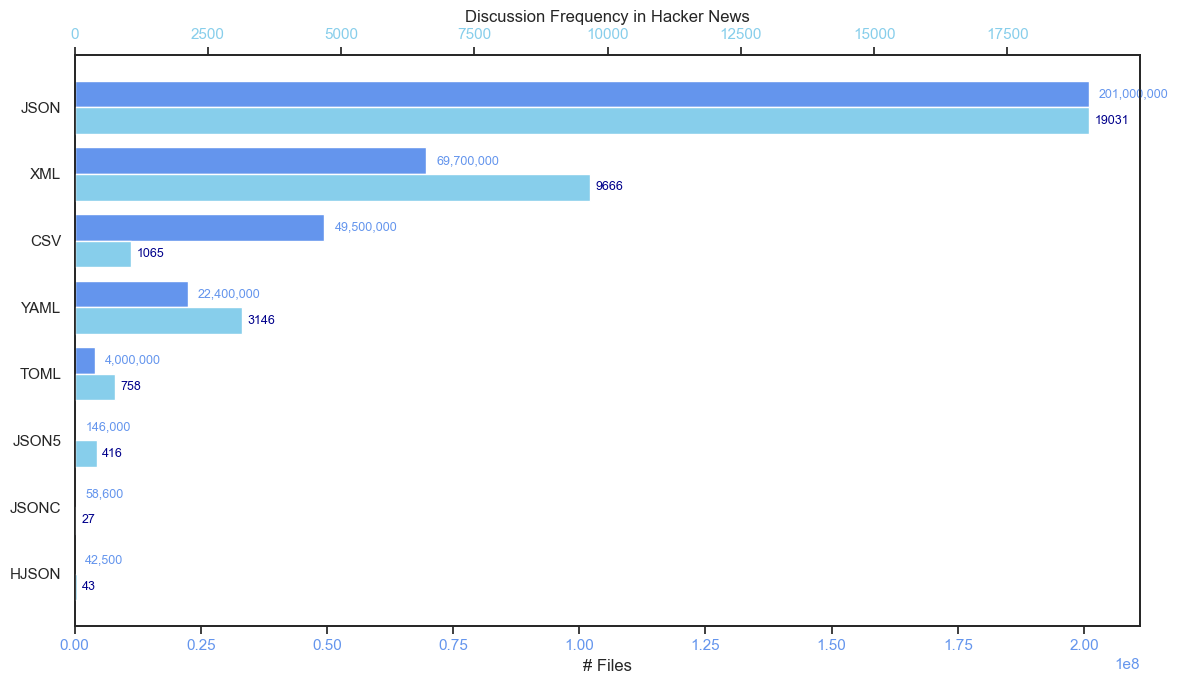

In [168]:
import matplotlib.pyplot as plt
import numpy as np

# 格式统一顺序
formats = ['JSON', 'XML', 'CSV', 'YAML', 'TOML', 'JSON5', 'JSONC', 'HJSON']
code_counts = [201_000_000, 69_700_000, 49_500_000, 22_400_000, 4_000_000, 146_000, 58_600, 42_500]
hn_freqs = [19031, 9666, 1065, 3146, 758, 416, 27, 43]

# 图形参数
y_pos = np.arange(len(formats))
bar_width = 0.4

# 可视化
fig, ax1 = plt.subplots(figsize=(12, 7))

# 左侧：Code Count
bars1 = ax1.barh(y_pos - bar_width/2, code_counts, height=bar_width, color='cornflowerblue', label='# Code')
ax1.set_xlabel('# Files', fontsize=12)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(formats)
ax1.invert_yaxis()
ax1.tick_params(axis='x', labelcolor='cornflowerblue')

# 右侧：Hacker News frequency（共用 y 轴）
ax2 = ax1.twiny()
bars2 = ax2.barh(y_pos + bar_width/2, hn_freqs, height=bar_width, color='skyblue', label='HN Mentions')
ax2.set_xlabel('Discussion Frequency in Hacker News', fontsize=12)
ax2.tick_params(axis='x', labelcolor='skyblue')

# 添加数值标签
for bar, val in zip(bars1, code_counts):
    ax1.text(bar.get_width() + 2e6, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', color='cornflowerblue', fontsize=9)

for bar, val in zip(bars2, hn_freqs):
    ax2.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, f'{val}', va='center', color='darkblue', fontsize=9)

# 标题 & 图例
# plt.title('Code Usage vs Hacker News Discussion per Format', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()


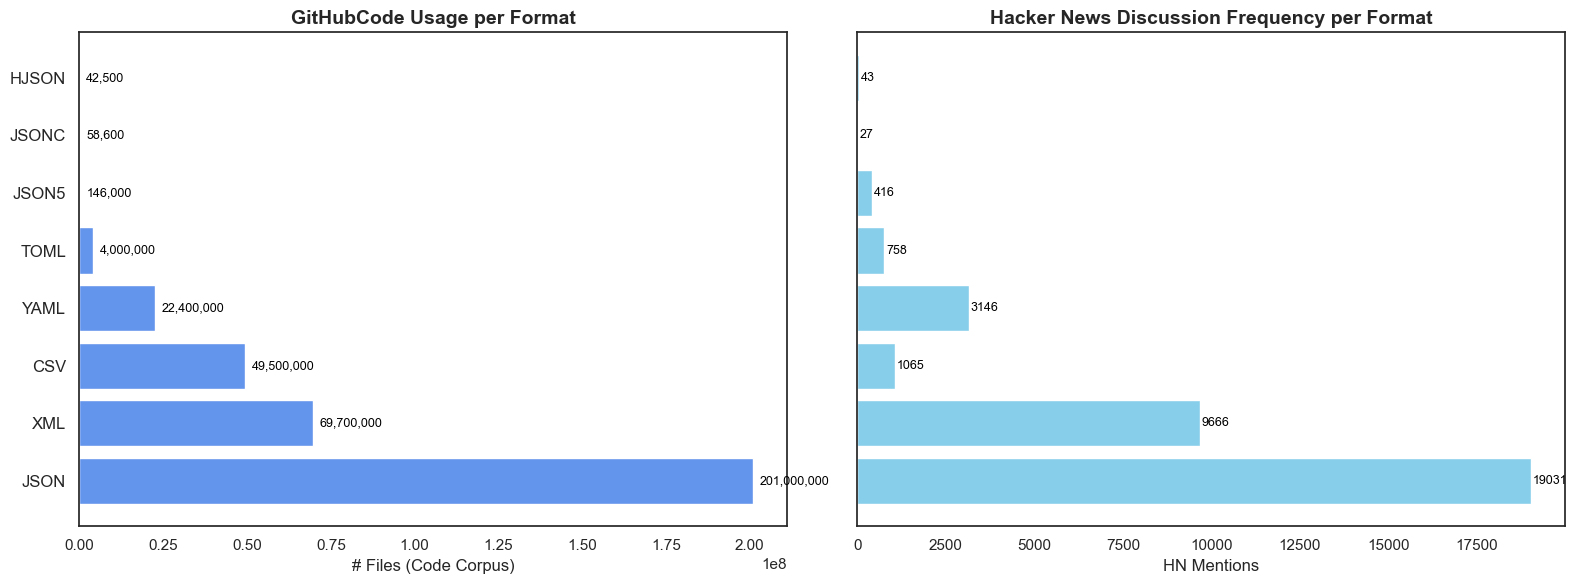

In [173]:
import matplotlib.pyplot as plt
import numpy as np

formats = ['JSON', 'XML', 'CSV', 'YAML', 'TOML', 'JSON5', 'JSONC', 'HJSON']
code_counts = [201_000_000, 69_700_000, 49_500_000, 22_400_000, 4_000_000, 146_000, 58_600, 42_500]
hn_freqs = [19031, 9666, 1065, 3146, 758, 416, 27, 43]
y_pos = np.arange(len(formats))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# 左图
bars1 = ax1.barh(y_pos, code_counts, color='cornflowerblue')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(formats, fontsize=12)
ax1.set_xlabel('# Files (Code Corpus)', fontsize=12)
ax1.set_title('GitHubCode Usage per Format', fontsize=14, weight='bold')
ax1.invert_yaxis()
for bar, val in zip(bars1, code_counts):
    ax1.text(bar.get_width() + 2e6, bar.get_y() + bar.get_height() / 2,
             f'{val:,}', va='center', color='black', fontsize=9)

# 右图
bars2 = ax2.barh(y_pos, hn_freqs, color='skyblue')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(formats, fontsize=12)  # 右侧也显示
ax2.set_xlabel('HN Mentions', fontsize=12)
ax2.set_title('Hacker News Discussion Frequency per Format', fontsize=14, weight='bold')
ax2.invert_yaxis()
for bar, val in zip(bars2, hn_freqs):
    ax2.text(bar.get_width() + 50, bar.get_y() + bar.get_height() / 2,
             f'{val}', va='center', color='black', fontsize=9)

plt.tight_layout()
plt.show()